# Tristan Albatross Satellite Imagery Count Analysis

<font size="4">Written by Marie RG Attard, 6 December 2024. Python 3.9.11 [MSC v.1931 64 bit (AMD64)]. Run on Jupyter Notebook.

Description:
The Tristan Albatross Satellite Imagery Count Analysis script processes satellite and observer data to evaluate the accuracy of identifying Tristan albatross nests. The workflow involves hierarchical clustering of observer data, spatial filtering, and validation against ground-truth nest locations using GPS. Metrics such as precision, recall, and F1-score are calculated to assess observer performance relative to gold-standard satellite annotations and nest GPS co-ordinates from ground surveys.

The script also aggregates nest and cluster counts per geographic tile, performs regression analysis to explore relationships between these counts, and visualises results through scatter plots. The analysis aims to quantify the reliability of satellite-based nest detection by comparing multiple observers to a gold standard and active nest data, ensuring robust data handling with quality control measures throughout. Results are output as tables and plots.
</font>

<font size="3">Import essential libraries for data manipulation, visualisation, statistical analysis, geospatial data handling, machine learning, and hierarchical clustering. It provides the foundational tools needed for tasks such as data preprocessing, clustering, regression analysis, and plotting results.<font size>

# Change the current working directory

In [1]:
#Manual installation of dependancies one by one.
#If install requirements.txt does not work, install each dependancy mannually, as follows: 

## System and utility imports
import os
import sys
import logging
import glob
import math
import random
import json
import ujson
from collections import defaultdict
from itertools import combinations
from pprint import pprint

## Data manipulation and analysis
import numpy as np  # Numerical computations
import pandas as pd  # Data analysis and manipulation

## Visualization
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Advanced data visualization
from matplotlib.lines import Line2D  # Custom legends and lines

## Image processing
from PIL import Image  # Handling image files

## GIS and raster data
import rasterio  # Handling geospatial raster data

## Statistical analysis
from scipy.stats import (
    shapiro,
    anderson,
    probplot,
    chi2_contingency,
    norm,
)

from scipy import stats 
from statsmodels.api import add_constant  # Model building utilities
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Hierarchical clustering and distances
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, cdist

## Machine learning
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

## Logistic regression (Statsmodels)
from statsmodels.discrete.discrete_model import Logit

<font size="3">Create a working directory and import multiple CSV files from a specific folder. It reads observer annotation data from these files, concatenates them into a single DataFrame, and extracts cx and cy coordinates from a JSON string in a column. Additionally, it cleans the data by removing unwanted columns and extracting a numeric tile ID from the filenames for further analysis.<font>

In [2]:
# Define the base directory for your project. Update this path based on your file's location.
root_dir = 'C:/Users/maratt/github_code/Tristan-albatross'

# Define subdirectories relative to the base directory
data_dir = os.path.join(root_dir, 'data')  # Contains all data (e.g., annotations, tiles) used as input for the script

#Subdirectory: Observer and reference annotations for othorectified satellite image
observer_annotations_dir = os.path.join(data_dir, 'observer_annotations')  # Stores raw observer annotation data
reference_annotations_dir = os.path.join(root_dir, 'data', 'reference_annotations', 'orthorectified', 'csv', 'Tristan_albatross_satellite_image_orthorectified_reference_gold_standard_labels.xlsx')  # Stores raw reference (2 experts) annotation data

#Subdirectory: Reference annotations for non-othorectified satellite image
notorth_reference_annotations_dir = os.path.join(root_dir, 'data', 'reference_annotations', 'not_orthorectified', 'csv', 'Tristan_albatross_satellite_image_notorthorectified_reference_gold_standard_labels.xlsx')  # Stores raw reference (2 experts) annotation data

#Subdirectory: tile (jpegs) and georeferenced coordinates
tile_dir = os.path.join(root_dir, 'data', 'tiles') # Stores the 30 satellite image tiles (jpeg format), to be used to visualise the observer, reference annotations and nest GPS coordinates
tile_cood_dir = os.path.join(root_dir, 'data', 'tile_coordinates_georeference', 'satellite_image_tile_georeference_coordinates.xlsx') # Stores Excel file with latitude and longitude of top-left cell of each tile, to be used in the script for georeferencing the tiles (jpeg images)

#Subdirectory: Nest GPS data (nest_dir) and incubating bird data (bird_dir) from ground survey
nest_dir = os.path.join(data_dir, 'nest_GPS_coordinates', 'nest_gps_coordinates.csv')  # Stores nest data from ground survey
bird_dir = os.path.join(data_dir, 'nesting_bird_information')

#Output subdirectory
output_dir = os.path.join(root_dir, 'output')  # Stores all outputs generated by the script

<font size="3">Processes CSV files containing the 9 observer annotations, loading them into a single DataFrame. Extracts the center coordinates (cx and cy) from a JSON column and assigns unique observer IDs based on the observer's initials. Cleans the data by removing unnecessary columns and drops rows with missing center coordinates for further analysis.</font>

In [3]:
import os
import pandas as pd
import json

# Create a list to hold DataFrames
observer_dataframes = []

# Iterate over all files in the directory
for filename in os.listdir(observer_annotations_dir):
    # Check if the file is a CSV file
    if filename.endswith('.csv'):
        # Create the full path to the file
        file_path = os.path.join(observer_annotations_dir, filename)
        
        # Try to read the CSV file and append the DataFrame to the list
        try:
            df = pd.read_csv(file_path)
            observer_dataframes.append(df)
            print(f"Successfully loaded: {filename}")
        except Exception as e:
            print(f"Failed to load {filename}: {e}")

# If you want to concatenate all DataFrames into one
if observer_dataframes:
    observer_annotations = pd.concat(observer_dataframes, ignore_index=True)
    print("All observer data loaded successfully.")
    print(observer_annotations.head())  # Display the first few rows of the concatenated DataFrame
else:
    print("No observer data files were found.")

# Define a function to extract cx and cy from the JSON string
def extract_cy_cx(region_shape):
    try:
        # Convert the string representation of the dictionary to a dictionary
        shape_dict = json.loads(region_shape)
        # Extract cx and cy, using get to avoid errors if they are missing
        return shape_dict.get('cx', None), shape_dict.get('cy', None)
    except (ValueError, TypeError) as e:
        print(f"Error parsing region_shape_attributes: {e}")
        return None, None  # Return None if there's an error

# Apply the function to the region_shape_attributes column
observer_annotations[['cx', 'cy']] = observer_annotations['region_shape_attributes'].apply(
    lambda x: pd.Series(extract_cy_cx(x))
)

# Drop the specified columns: region_shape_attributes, file_attributes, and region_attributes
observer_annotations.drop(columns=['region_shape_attributes', 'file_attributes', 'region_attributes'], inplace=True)

# Display the updated DataFrame with the new columns
print("Updated DataFrame after extracting cx and cy:")
print(observer_annotations.head())  # Shows the first few rows of the updated DataFrame

# Extract the tile_ID from the filename column
observer_annotations['tile_ID'] = observer_annotations['filename'].str.extract(r'_(\d+)\.jpg')

# Convert tile_ID to numeric (optional, depending on whether you want it as a number)
observer_annotations['tile_ID'] = pd.to_numeric(observer_annotations['tile_ID'], errors='coerce')  # 'coerce' converts invalid parsing to NaN

# Allocate ID number to each observer
observer_ID = {
    "EB": "obs1",  # Experience in satellite imagery to detect/count wildlife
    "HC": "obs2",  # Experience in satellite imagery to detect/count wildlife
    "CB": "obs3",  # Experience in satellite imagery to detect/count wildlife
    "NR": "obs4",  # Albatross fieldwork experience
    "EP": "obs5",  # Albatross fieldwork experience
    "MB": "obs6",  # Albatross fieldwork experience
    "ST": "obs7",  # No satellite imagery or albatross fieldwork experience
    "CA": "obs8",  # No satellite imagery or albatross fieldwork experience
    "HM": "obs9"  # No satellite imagery or albatross fieldwork experience
}

# Map the observer ID to the DataFrame and create a new column
observer_annotations['observer_ID'] = observer_annotations['observer'].map(observer_ID)

# Display the DataFrame to view its contents
print("Data after assigning observer IDs:")
print(observer_annotations.head())

# Remove rows where the 'cx' column is blank (NaN)
rows_before = len(observer_annotations)
observer_annotations = observer_annotations.dropna(subset=['cx'])
rows_after = len(observer_annotations)

# Log how many rows were removed
print(f"Removed {rows_before - rows_after} rows due to missing 'cx' values.")


Successfully loaded: CA_via_project_22Jul2022_12h56m_csv.csv
Successfully loaded: CB_via_project_18Jul2022_16h25m_csv.csv
Successfully loaded: EB_via_project_19Jul2022_9h22m_csv.csv
Successfully loaded: EP_via_project_10Aug2022_13h8m_csv.csv
Successfully loaded: HC_via_project_26Jul2022_16h5m_csv.csv
Successfully loaded: HM_via_project_20Jul2022_16h1m_csv.csv
Successfully loaded: MB_via_project_25Aug2022_15h23m_csv.csv
Successfully loaded: NR_via_project_27Jul2022_11h31m_csv.csv
Successfully loaded: ST_via_project_2Aug2022_10h45m_csv.csv
All observer data loaded successfully.
  observer                      filename  file_size file_attributes  \
0       CA  1_Gough_Island_100m2_259.jpg      52903              {}   
1       CA  1_Gough_Island_100m2_259.jpg      52903              {}   
2       CA   2_Gough_Island_100m2_56.jpg      56973              {}   
3       CA   3_Gough_Island_100m2_57.jpg      61766              {}   
4       CA  4_Gough_Island_100m2_147.jpg      49628           

<font size="3">Search for all tiles (.jpg files) within a specified directory and its subfolders. It collects the full file paths, extracts just the file names, and prints the resulting list of file names. The directory to search is defined by the jpg_path variable.<font>

In [4]:
# Use glob to find all jpg files recursively in the 'tile' folder using tile relative directory (tile_dir)
jpg_files_with_path = glob.glob(os.path.join(tile_dir, '**', '*.jpg'), recursive=True)

# Extract just the file names from the full paths
jpg_filename = [os.path.basename(file) for file in jpg_files_with_path]

# Display the list of file names
print(jpg_filename)

['10_Gough_Island_100m2_132.jpg', '11_Gough_Island_100m2_134.jpg', '12_Gough_Island_100m2_151.jpg', '13_Gough_Island_100m2_164.jpg', '14_Gough_Island_100m2_165.jpg', '15_Gough_Island_100m2_166.jpg', '16_Gough_Island_100m2_168.jpg', '17_Gough_Island_100m2_169.jpg', '18_Gough_Island_100m2_171.jpg', '19_Gough_Island_100m2_199.jpg', '1_Gough_Island_100m2_259.jpg', '20_Gough_Island_100m2_254.jpg', '21_Gough_Island_100m2_203.jpg', '22_Gough_Island_100m2_204.jpg', '23_Gough_Island_100m2_222.jpg', '24_Gough_Island_100m2_102.jpg', '25_Gough_Island_100m2_239.jpg', '26_Gough_Island_100m2_240.jpg', '27_Gough_Island_100m2_286.jpg', '28_Gough_Island_100m2_257.jpg', '29_Gough_Island_100m2_260.jpg', '2_Gough_Island_100m2_56.jpg', '30_Gough_Island_100m2_224.jpg', '3_Gough_Island_100m2_57.jpg', '4_Gough_Island_100m2_147.jpg', '5_Gough_Island_100m2_200.jpg', '6_Gough_Island_100m2_79.jpg', '7_Gough_Island_100m2_83.jpg', '8_Gough_Island_100m2_106.jpg', '9_Gough_Island_100m2_160.jpg']


<font size="3">Process satellite image tiles by matching them with georeferenced data and observer annotations. It loops through each image file, plots the image, and overlays observer annotations at specific pixel locations. These pixel coordinates are converted into latitude and longitude based on georeference data, and the annotated images are saved to a designated output directory for further analysis.<font>

In [5]:
# Read the "tile_ID_lat_long" sheet
coord_data = pd.read_excel(tile_cood_dir, sheet_name='tile_ID_lat_long')

# Set the cell size in meters
cell_size = 0.3  # meters per pixel

# Add two new columns for georeferenced latitude and longitude
observer_annotations['georef_lat'] = None
observer_annotations['georef_long'] = None

# Loop through each unique file in observer_annotations
for test_image_file in observer_annotations['filename'].unique():
    
    # Extract the matching georeference data for the same image file
    tile_georef = coord_data[coord_data['filename'] == test_image_file]
    
    if tile_georef.empty:
        print(f"No georeference data found for {test_image_file}")
        continue  # Skip this image file if no georeference data is available
    else:
        # Print success message for georeference data found
        print(f"Georeference data found for {test_image_file}")
        
        first_cell_lat = tile_georef['first_cell_lat'].values[0]
        first_cell_long = tile_georef['first_cell_long'].values[0]
        
        # Filter the DataFrame for the specific image in observer_annotations
        subset_df = observer_annotations[observer_annotations['filename'] == test_image_file]
        
        # Calculate georeferenced coordinates for each point in this subset
        for idx, row in subset_df.iterrows():
            x = row['cx']  # pixel column (x-coordinate in the image)
            y = row['cy']  # pixel row (y-coordinate in the image)
            
            # Calculate georeferenced latitude and longitude of the point
            pixel_lat = first_cell_lat - ((y * cell_size) / 111320)  # latitude decreases as row index increases
            pixel_long = first_cell_long + ((x * cell_size) / (111320 * math.cos(math.radians(first_cell_lat))))  # adjust for longitude at current latitude
            
            # Update the corresponding row in observer_annotations with new lat/long
            observer_annotations.at[idx, 'georef_lat'] = pixel_lat
            observer_annotations.at[idx, 'georef_long'] = pixel_long
        
        # Print a message indicating the processing of this file has completed
        print(f"Georeference processing completed for {test_image_file}")

# Optionally, print out a sample of the updated DataFrame to confirm the new columns
print("Sample of updated observer_annotations with georeferenced coordinates:")
print(observer_annotations.head())


Georeference data found for 1_Gough_Island_100m2_259.jpg
Georeference processing completed for 1_Gough_Island_100m2_259.jpg
Georeference data found for 2_Gough_Island_100m2_56.jpg
Georeference processing completed for 2_Gough_Island_100m2_56.jpg
Georeference data found for 3_Gough_Island_100m2_57.jpg
Georeference processing completed for 3_Gough_Island_100m2_57.jpg
Georeference data found for 5_Gough_Island_100m2_200.jpg
Georeference processing completed for 5_Gough_Island_100m2_200.jpg
Georeference data found for 6_Gough_Island_100m2_79.jpg
Georeference processing completed for 6_Gough_Island_100m2_79.jpg
Georeference data found for 7_Gough_Island_100m2_83.jpg
Georeference processing completed for 7_Gough_Island_100m2_83.jpg
Georeference data found for 8_Gough_Island_100m2_106.jpg
Georeference processing completed for 8_Gough_Island_100m2_106.jpg
Georeference data found for 10_Gough_Island_100m2_132.jpg
Georeference processing completed for 10_Gough_Island_100m2_132.jpg
Georeference d

<font size="5">References, gold standard and observer annotations in orthorectified satellite image<font size>

<font size="3">Add the references and gold standard labels to the observer_annotations georeferenced database.<font size>

In [6]:
# Load the 'reference' sheet for the original annotations from ref 1 and ref 2
reference_annotations = pd.read_excel(reference_annotations_dir, sheet_name='reference')

# Load the 'gold_standard' sheet for the concensus between ref 1 and ref 2
goldstandard_annotations = pd.read_excel(reference_annotations_dir, sheet_name='gold_standard')

# Merge reference_data with coord_data to add the filename based on matching tile_ID
reference_annotations_with_filenames_and_tileIDs= pd.merge(reference_annotations, 
                           coord_data[['tile_ID', 'filename']],  # Selecting relevant columns from coord_data
                           on='tile_ID', 
                           how='left')

# Merge reference_data with coord_data to add the filename based on matching tile_ID
goldstandard_annotations_with_filenames_and_tileIDs = pd.merge(goldstandard_annotations, 
                           coord_data[['tile_ID', 'filename']],  # Selecting relevant columns from coord_data
                           on='tile_ID', 
                           how='left')

# Concatenate gold_standard_data and reference_data row-wise, keeping all rows and columns the same
ref_gold_annotations = pd.concat([goldstandard_annotations_with_filenames_and_tileIDs, reference_annotations_with_filenames_and_tileIDs], ignore_index=True)


# Save observer_ref_gold_georeferenced
output_csv_path = os.path.join(output_dir, 'reference_goldstandard_all_annotations.csv')
ref_gold_annotations.to_csv(output_csv_path, index=False)
print(f"Exported as '{output_csv_path}'.")

print(ref_gold_annotations)

Exported as 'C:/Users/maratt/github_code/Tristan-albatross\output\reference_goldstandard_all_annotations.csv'.
          observer    observer_ID   latitude  longitude image_correction  \
0    gold standard  gold standard -40.337658  -9.923429   orthorectified   
1    gold standard  gold standard -40.337915  -9.922528   orthorectified   
2    gold standard  gold standard -40.338493  -9.923349   orthorectified   
3    gold standard  gold standard -40.338711  -9.922585   orthorectified   
4    gold standard  gold standard -40.338509  -9.920864   orthorectified   
..             ...            ...        ...        ...              ...   
320             PC          ref 2 -40.341015  -9.915277   orthorectified   
321             PC          ref 2 -40.348376  -9.910711   orthorectified   
322             PC          ref 2 -40.348083  -9.910700   orthorectified   
323             PC          ref 2 -40.342003  -9.919695   orthorectified   
324             PC          ref 2 -40.337606  -9.9175

Process reference and gold standard annotations, calculating region counts per observer and tile. It filters the annotations based on matching tile IDs and merges the observer data with these filtered annotations. The combined dataset is then exported to a CSV file for further analysis.

In [7]:
# Calculate the counts for each observer and tile_ID
annotation_counts = ref_gold_annotations.groupby(['observer_ID', 'tile_ID']).size().reset_index(name='region_count')

# Merge the counts back into the original reference_goldstandard annotations DataFrame
ref_gold_annotations = ref_gold_annotations.merge(annotation_counts, on=['observer_ID', 'tile_ID'], how='left')

# Filter reference_goldstandard annotations to keep only rows with tile_IDs that are also in coord_data
ref_gold_tile_annotations = ref_gold_annotations[ref_gold_annotations['tile_ID'].isin(coord_data['tile_ID'])]

# Export the filtered data to a CSV file in the output folder
output_csv_path = os.path.join(output_dir, 'ref_goldstandard_annotations_30_tiles.csv')
ref_gold_tile_annotations.to_csv(output_csv_path, index=False)

# Concatenate the observer annotations with the filtered reference and gold standard annotations
combined_tile_annotations = pd.concat([observer_annotations, ref_gold_tile_annotations], ignore_index=True, sort=False)

# Define the final output path. Save the combined data to a CSV.
#combined_output_csv_path = os.path.join(output_dir, 'observer_ref_goldstandard_annotations_30_tiles.csv')
#combined_tile_annotations.to_csv(combined_output_csv_path, index=False)

# Display the first few rows of the combined data
combined_tile_annotations.head()

observer                      filename  file_size  region_count  region_id  \
0       CA  1_Gough_Island_100m2_259.jpg    52903.0             2        0.0   
1       CA  1_Gough_Island_100m2_259.jpg    52903.0             2        1.0   
2       CA   2_Gough_Island_100m2_56.jpg    56973.0             1        0.0   
3       CA   3_Gough_Island_100m2_57.jpg    61766.0             1        0.0   
4       CA  5_Gough_Island_100m2_200.jpg    53128.0             1        0.0   

      cx     cy  tile_ID observer_ID georef_lat georef_long  latitude  \
0  138.0   24.0      259        obs8 -40.335575   -9.916313       NaN   
1  243.0  213.0      259        obs8 -40.336084   -9.915942       NaN   
2  286.0  304.0       56        obs8 -40.348088   -9.910061       NaN   
3  154.0  277.0       57        obs8 -40.348025   -9.909351       NaN   
4  230.0   88.0      200        obs8 -40.338412   -9.920736       NaN   

   longitude image_correction comments  
0        NaN              NaN      NaN  
1        NaN              NaN      NaN  
2        NaN              NaN      NaN  
3        NaN              NaN      NaN  
4        NaN              NaN      NaN

Add pixel width and height for each satellite image tile, assuming each pixel corresponds to a 100m x 100m area. It reads tile coordinate data from an Excel file, retrieves image dimensions from JPEG files, and merges this information 
into the observer_annotations DataFrame, which is then exported to a new CSV file.

In [8]:
#Add pixel width and height for each tile. The pixels should equate to 100 m x 100 m. 

# Extract just the file names from the full paths
jpg_filenames = [os.path.basename(file) for file in jpg_files_with_path]

# Initialize lists to hold the pixel dimensions
widths = []
heights = []

# Loop through each tile in the coord_data
for index, row in coord_data.iterrows():
    filename = row['filename']  # Assuming there's a 'filename' column in coord_data

    # Check if the filename is in the list of JPEG filenames
    if filename in jpg_filenames:
        # Construct the full path to the image file
        img_path = os.path.join(tile_dir, filename)
        
        # Open the image to get its dimensions
        with Image.open(img_path) as img:
            width, height = img.size  # Get image dimensions
            widths.append(width)
            heights.append(height)
    else:
        print(f"Image file not found: {filename}")
        widths.append(None)  # Append None if the image does not exist
        heights.append(None)
        
# Add pixel dimensions as new columns in coord_data
coord_data['pixel_width'] = widths
coord_data['pixel_height'] = heights

# Save revised satellite image georeference coordinates
output_excel_path = os.path.join(output_dir, 'revised_satellite_image_tile_georeference_coordinates.xlsx')
coord_data.to_excel(output_excel_path, index=False) 
print(f"Pixel dimensions added. The updated coord_data DataFrame now contains 'pixel_width' and 'pixel_height' columns. Exported as '{output_excel_path}'.")

# Merge pixel_width and pixel_height into observer_annotations based on filename
observer_annotations = observer_annotations.merge(coord_data[['filename', 'pixel_width', 'pixel_height']], 
                                             on='filename', 
                                             how='left')

# Save
output_csv_path = os.path.join(output_dir, '3_observer_annotations_georeferenced.csv')
observer_annotations.to_csv(output_csv_path, index=False)
print(f"Georeferencing complete. The 'observer_annotations' DataFrame now contains 'georef_lat' and 'georef_long' columns. Exported as '{output_csv_path}'.")

Pixel dimensions added. The updated coord_data DataFrame now contains 'pixel_width' and 'pixel_height' columns. Exported as 'C:/Users/maratt/github_code/Tristan-albatross\output\revised_satellite_image_tile_georeference_coordinates.xlsx'.
Georeferencing complete. The 'observer_annotations' DataFrame now contains 'georef_lat' and 'georef_long' columns. Exported as 'C:/Users/maratt/github_code/Tristan-albatross\output\3_observer_annotations_georeferenced.csv'.


Plot the tiles and observer labels using pixel coordinates and non-georeferenced image.

<ipython-input-9-359a726f9fbf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'latitude'] = latitudes
<ipython-input-9-359a726f9fbf>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'longitude'] = longitudes


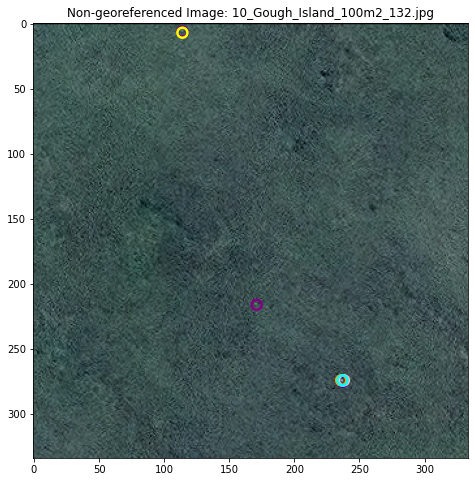

<ipython-input-9-359a726f9fbf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'latitude'] = latitudes
<ipython-input-9-359a726f9fbf>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'longitude'] = longitudes


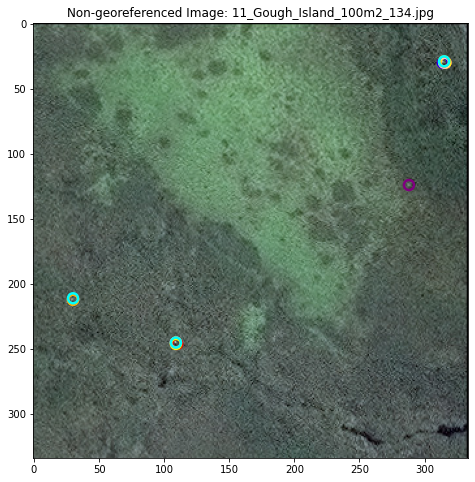

<ipython-input-9-359a726f9fbf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'latitude'] = latitudes
<ipython-input-9-359a726f9fbf>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'longitude'] = longitudes


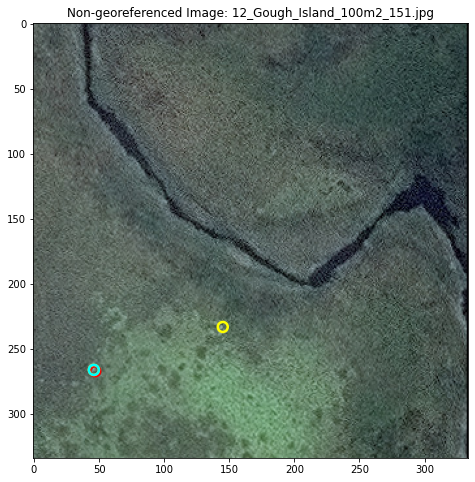

<ipython-input-9-359a726f9fbf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'latitude'] = latitudes
<ipython-input-9-359a726f9fbf>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'longitude'] = longitudes


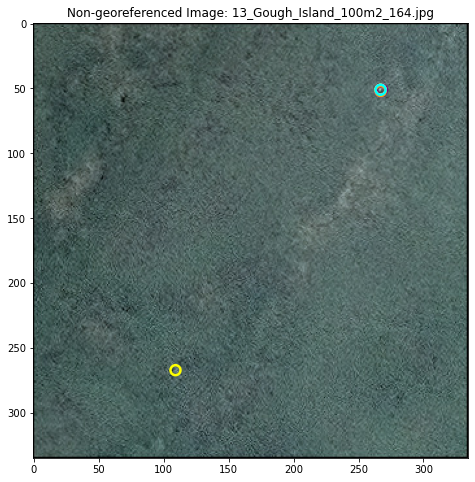

<ipython-input-9-359a726f9fbf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'latitude'] = latitudes
<ipython-input-9-359a726f9fbf>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'longitude'] = longitudes


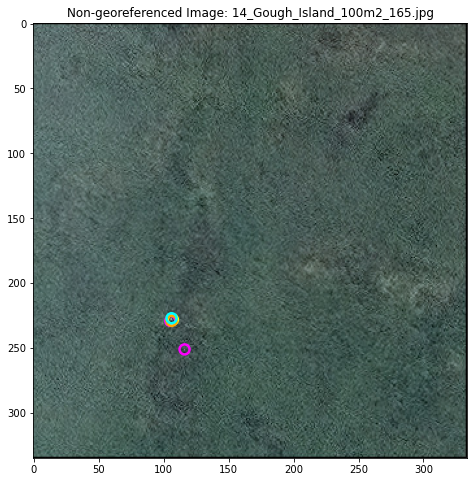

<ipython-input-9-359a726f9fbf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'latitude'] = latitudes
<ipython-input-9-359a726f9fbf>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'longitude'] = longitudes


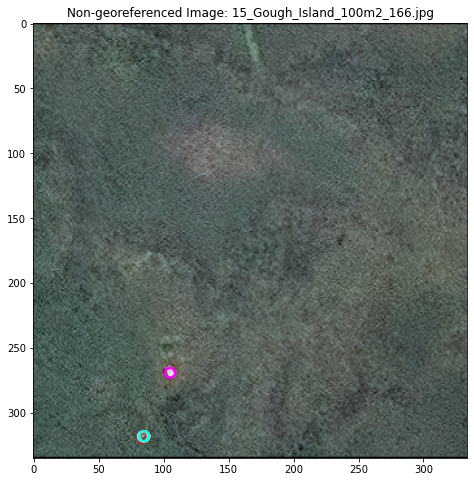

<ipython-input-9-359a726f9fbf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'latitude'] = latitudes
<ipython-input-9-359a726f9fbf>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'longitude'] = longitudes


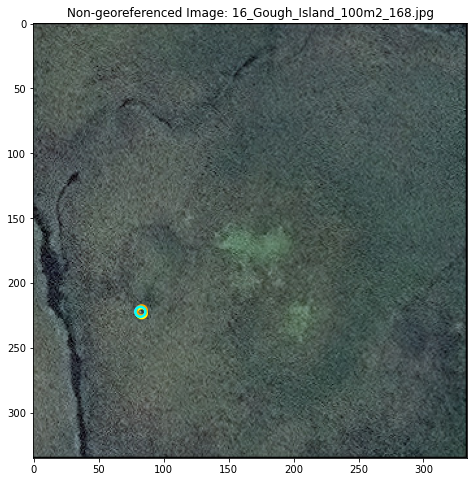

<ipython-input-9-359a726f9fbf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'latitude'] = latitudes
<ipython-input-9-359a726f9fbf>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'longitude'] = longitudes


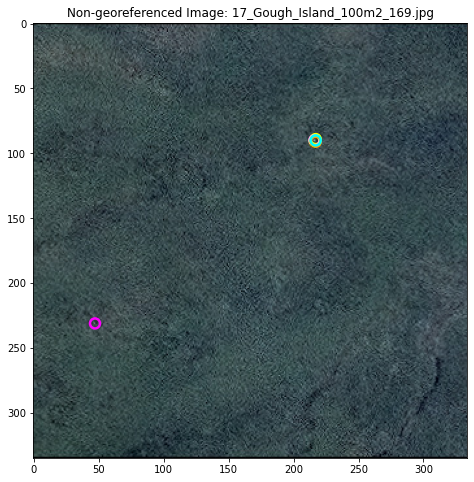

<ipython-input-9-359a726f9fbf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'latitude'] = latitudes
<ipython-input-9-359a726f9fbf>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'longitude'] = longitudes


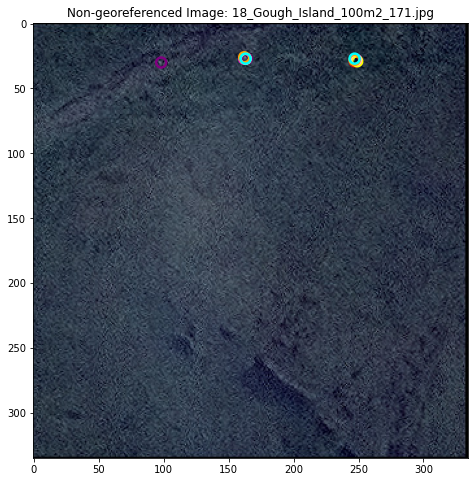

<ipython-input-9-359a726f9fbf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'latitude'] = latitudes
<ipython-input-9-359a726f9fbf>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'longitude'] = longitudes


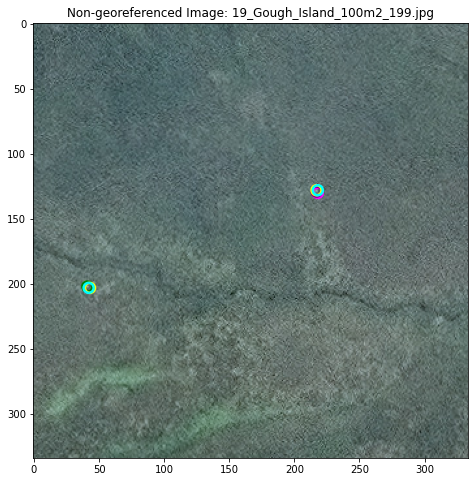

<ipython-input-9-359a726f9fbf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'latitude'] = latitudes
<ipython-input-9-359a726f9fbf>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'longitude'] = longitudes


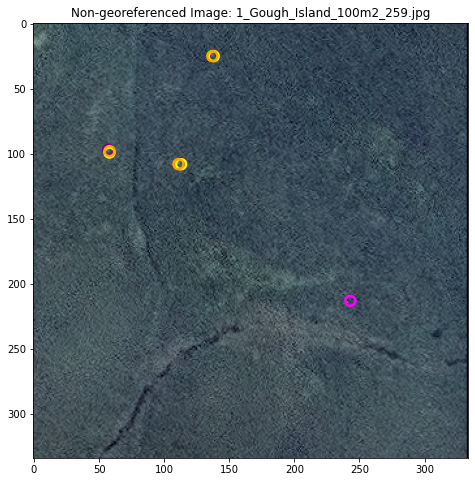

<ipython-input-9-359a726f9fbf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'latitude'] = latitudes
<ipython-input-9-359a726f9fbf>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'longitude'] = longitudes


In [ ]:
#Loop code through all images

# Ensure the 'tile_images' directory exists
tile_with_labels_dir = os.path.join(output_dir, 'tile_images')
os.makedirs(tile_with_labels_dir, exist_ok=True)

# Ensure the 'tile_with_raw_observer_labels' subdirectory exists within 'tile_images'
tile_with_labels_raw_dir = os.path.join(tile_with_labels_dir, 'tiles_with_raw_observer_labels_not_georeferenced')
os.makedirs(tile_with_labels_raw_dir, exist_ok=True)

# Set the cell size in meters
cell_size = 0.3  # meters per pixel

# Create a color map for observers
observer_color_map = {
    'obs1': 'blue',
    'obs2': 'green',
    'obs3': 'red',
    'obs4': 'orange',
    'obs5': 'purple',
    'obs6': 'pink',
    'obs7': 'cyan',
    'obs8': 'magenta',
    'obs9': 'yellow'
}

# Loop through all files in the directory
for test_image_file in os.listdir(tile_dir):
    if test_image_file.endswith('.jpg'):
        # Filter the DataFrame for the specific image in observer_annotations
        subset_df = observer_annotations[observer_annotations['filename'] == test_image_file]

        # Extract the matching georeference data for the same image file
        tile_georef = coord_data[coord_data['filename'] == test_image_file]

        if tile_georef.empty:
            print(f"No georeference data found for {test_image_file}")
            continue

        first_cell_lat = tile_georef['first_cell_lat'].values[0]
        first_cell_long = tile_georef['first_cell_long'].values[0]

        # Load the image
        img_path = os.path.join(tile_dir, test_image_file)
        image = Image.open(img_path)

        # Set the figure size and plot the image
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.imshow(image)

        # Initialize lists to hold georeferenced coordinates
        latitudes = []
        longitudes = []

        # Loop through the observer data and plot the points with georeferenced coordinates
        for _, row in subset_df.iterrows():
            x = row['cx']  # pixel column (x-coordinate in the image)
            y = row['cy']  # pixel row (y-coordinate in the image)

            # Calculate georeferenced latitude and longitude of the point
            pixel_lat = first_cell_lat - ((y * cell_size) / 111320)  # latitude decreases as row index increases
            pixel_long = first_cell_long + ((x * cell_size) / (111320 * math.cos(math.radians(first_cell_lat))))  # adjust for longitude at current latitude

            latitudes.append(pixel_lat)
            longitudes.append(pixel_long)

            observer_color = observer_color_map[row['observer_ID']]  # Get color for observer

            # Plot points with transparent fill and different outline colors for each observer
            ax.scatter(x, y, facecolors='none', edgecolors=observer_color, linewidth=2.5, marker='o', s=100)

        # Add latitude and longitude columns to subset DataFrame using .loc to avoid the SettingWithCopyWarning
        subset_df.loc[:, 'latitude'] = latitudes
        subset_df.loc[:, 'longitude'] = longitudes

        # Update the original observer_annotations DataFrame with the new georeferenced information
        observer_annotations.update(subset_df)

        # Set the title for the plot
        ax.set_title(f"Non-georeferenced Image: {test_image_file}")

     # Save the annotated image to the specified output directory
        output_img_path = os.path.join(tile_with_labels_raw_dir, test_image_file)
        plt.savefig(output_img_path, bbox_inches='tight', dpi=300)  # Save with higher DPI
        plt.show()
        plt.close()

Convert the georeferenced images as a GeoTIFF, save it, and then plot it in a Jupyter notebook with observer points  and nest GPS coordinates superimposed using latitude and longitude coordinates. Squares are the observer points and circle is the nest GPS coordinates. 
1. Create GeoTIFF images for each tile using first_cell_lat and first_cell_long.
2. Superimpose observer points over the GeoTIFF using latitude and longitude.
3. Display the images with observer points in Jupyter Notebook.

In [ ]:
# Load the nest GPS coordinates data
nest_data = pd.read_csv(nest_dir)

#Manually move nest (ID 13318) 30 cm to the left. This nest is just outside the tile '6_Gough_Island_100m2_79.jpg', but matches observer label within the tile. 
# Display the original coordinates for nest_ID 13318
original_coordinates = nest_data[nest_data['nest_ID'] == 13318][['nest_ID', 'nest_latitude', 'nest_longitude']]
print("Original coordinates for nest_ID 13318:")
print(original_coordinates)

# Calculate the new coordinates
shift_cm = 0.3  # Shift in meters
meters_to_degrees = 1 / 111320  # Conversion factor from meters to degrees
longitude_shift = shift_cm * meters_to_degrees  # Calculate the shift in degrees

# Update the coordinates for nest_ID 13318
nest_data.loc[nest_data['nest_ID'] == 13318, 'nest_longitude'] -= longitude_shift

# Display the updated coordinates
updated_coordinates = nest_data[nest_data['nest_ID'] == 13318][['nest_ID', 'nest_latitude', 'nest_longitude']]
print("Updated coordinates for nest_ID 13318:")
print(updated_coordinates)

# Save observer_ref_gold_georeferenced
output_csv_path = os.path.join(output_dir, 'nest_GPS_data.csv')
observer_annotations.to_csv(output_csv_path, index=False)
print(f"Georeferencing complete. The 'nest_data' DataFrame now has revised latititude longitude columns. Exported as '{output_csv_path}'.")

# Nest detection in orthorectified satellite images 
Compare georeferenced points from ref 1, ref 2, and "gold standard" to the full set of nest data, calculating performance metrics such as Precision, Recall, and F1 Score. It tracks the number of true positives, false positives, and false negatives by identifying matches between observer points and nest locations within a specified tolerance. The results are compiled into a DataFrame and exported as a CSV file for further analysis.

In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to calculate metrics for each observer
def calculate_metrics(observer_id, ref_gold_annotations, nest_data, tolerance=0.000090579):  # 10 m tolerance in degrees
    observer_points = ref_gold_annotations[ref_gold_annotations['observer_ID'] == observer_id]

    # Initialize counts and sets
    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives
    matched_nests = set()  # To track matched nests
    identified_nests = set()  # To track identified nests by the observer

    for _, obs_row in observer_points.iterrows():
        obs_lat = obs_row['latitude']
        obs_long = obs_row['longitude']

        # Check for all nests within the tolerance
        matches = nest_data[
            (np.abs(nest_data['nest_latitude'] - obs_lat) <= tolerance) & 
            (np.abs(nest_data['nest_longitude'] - obs_long) <= tolerance)
        ]

        identified_nests.add(tuple(obs_row[['latitude', 'longitude']].values))  # Store coordinates as a tuple

        if not matches.empty:
            # Sort by distance
            matches['distance'] = np.sqrt((matches['nest_latitude'] - obs_lat) ** 2 + 
                                          (matches['nest_longitude'] - obs_long) ** 2)
            closest_nest = matches.loc[matches['distance'].idxmin()]

            # Only count as true positive if this nest hasn't been matched yet
            if closest_nest['nest_ID'] not in matched_nests:
                TP += 1
                matched_nests.add(closest_nest['nest_ID'])  # Mark this nest as matched

    # False Positives: All observer points minus true positives
    FP = len(observer_points) - TP

    # False Negatives: All nests minus matched nests
    for _, nest_row in nest_data.iterrows():
        if nest_row['nest_ID'] not in matched_nests:
            FN += 1

    # Calculate Precision, Recall, and F1 Score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate identified nests that were not matches
    identified_not_matches = len(identified_nests) - TP
    total_observer_points = len(observer_points)

    return precision, recall, f1, len(nest_data), TP, identified_not_matches, total_observer_points

# Calculate metrics for each unique observer using all nest data (no filtering)
results = []

# Define the observers to calculate metrics for: 'ref 1', 'ref 2', 'gold standard'
observer_ids = ['ref 1', 'ref 2', 'gold standard']

for observer in observer_ids:
    try:
        precision, recall, f1, total_nests, identified_nests, identified_not_matches, total_observer_points = calculate_metrics(
            observer, ref_gold_annotations, nest_data  # Use entire nest_data (no filtering)
        )
        results.append({
            'observer_ID': observer,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'total_nests': total_nests,  # Total nests in all nest data (no filtering)
            'identified_nests': identified_nests,  # Nests identified by the observer
            'identified_not_matches': identified_not_matches,  # Nests identified by the observer but not matched
            'total_observer_points': total_observer_points  # Total observer points recorded
        })
        logging.info(f"Metrics calculated for observer {observer}.")
    except Exception as e:
        logging.error(f"Error calculating metrics for observer {observer}: {e}")

# Create a DataFrame for results
ref_gold_metrics_df = pd.DataFrame(results)
print(ref_gold_metrics_df)

# Save ref and gold standard metrics compared to 152 nests.
#detection_metrics_ref_and_gold_standard_relative_to_nestGPS_all_satellite_image_orthorectified
output_csv_path = os.path.join(output_dir, 'Table_1.csv')
ref_gold_metrics_df.to_csv(output_csv_path, index=False)
print(f"Metrics exported successfully to '{output_csv_path}'")

Analyse potential factors influencing detectability of Tristan albatrosses using gold standard annotations

This section of the script calls in data about the incubating birds, including sex, age, slope and aspect. This data is combined. We then match the nest IDs with the gold standard annotations to determine which nests could be detected. Different statistical tests are run to determine whether nesting birds have a better chance of being detected based on their age, sex, nest slope or nest aspect.

In [ ]:
# Load data: age, visibility, and nest location information
age_dat = pd.read_csv(os.path.join(bird_dir, "Tristan_albatross_age_sex_data.csv"))  # Minimum age and sex of nesting birds.
vis_dat = pd.read_csv(os.path.join(bird_dir, "Tristan_albatross_nest_colony_information.csv"))  # Visibility data of nests.
slope_dat = pd.read_csv(os.path.join(bird_dir, "Tristan_albatross_nest_location_data.csv"))  # Slope and aspect of nests.

# Define the nest ID to check
nest_id_to_check = 13280  # Use an integer instead of a string

# Check if the specific `nest_ID` and `observation_before_after_satellite` combination exists
exists = (
    (age_dat['nest_ID'] == nest_id_to_check) &
    (age_dat['observation_before_after_satellite'] == 'after')
).any()

# If the combination doesn't exist, add the new row
if not exists:
    new_row = pd.DataFrame({
        'nest_ID': [nest_id_to_check],
        'nest_label': ['TRAL_2018_Gonydale14'], 
        'observation_before_after_satellite': ['after'],
        'bird_ID': ['GO-TRAL-2994'], 
        'date': [pd.NaT],  # Missing datetime
        'first_marked': ['2005-09-18T22:00:00Z'], 
        'age_class': ['Chick'], 
        'sex': ['Male'], 
        'minimum_age': [12]
    })

    # Ensure date columns are in datetime format
    age_dat['date'] = pd.to_datetime(age_dat['date'], errors='coerce')
    new_row['date'] = pd.to_datetime(new_row['date'], errors='coerce')

    # Add the new row to the dataset
    age_dat = pd.concat([age_dat, new_row], ignore_index=True)
    print(f"New row for nest_ID {nest_id_to_check} added successfully.")
else:
    print(f"Row for nest_ID {nest_id_to_check} with 'after' observation already exists.")

# Verify by filtering rows with the specified nest_ID
age_dat_filtered = age_dat[age_dat['nest_ID'] == nest_id_to_check]
print("filtered age_dat for nest_ID 13280:")
print(age_dat_filtered )

Filter data so if both male and female are at a nest, then only select the sex that was there both before and after. 

In [ ]:
# Subset the age data to include rows with non-missing `sex` and `nest_ID`
age_dat_subset = age_dat.dropna(subset=['sex', 'nest_ID'])

# Filter rows for 'before' and 'after' observations
before_after_filtered = age_dat_subset[
    age_dat_subset['observation_before_after_satellite'].isin(['before', 'after'])
]

# Group by `nest_ID` and `sex`, and filter groups that contain both 'before' and 'after'
valid_groups = before_after_filtered.groupby(['nest_ID', 'sex']).filter(
    lambda x: set(x['observation_before_after_satellite']) == {'before', 'after'}
)

# Reset the index for the resulting DataFrame
valid_groups = valid_groups.reset_index(drop=True)

# Save the filtered data back to the variable if desired
age_dat_subset = valid_groups

# Inspect the result
print("Filtered DataFrame with 'before' and 'after' observations:")
print(age_dat_subset)

# Export the cleaned subset to a CSV file
output_csv_path = os.path.join(output_dir, 'known_nests_age_dat_subset.csv')
age_dat_subset.to_csv(output_csv_path, index=False)
print(f"Filtered data exported successfully to '{output_csv_path}'")

In [ ]:
# Subset the age data to only include relevant information
age_dat_subset = age_dat.dropna(subset=['sex', 'nest_ID'])  # Remove rows with missing sex or nest ID

# First filter to get only the relevant 'before' and 'after' rows for each sex
# We will group by 'nest_ID' and 'sex' and check if there is at least one 'before' and one 'after'

# Filter for rows with 'before' and 'after'
before_after_filtered = age_dat_subset[age_dat_subset['observation_before_after_satellite'].isin(['before', 'after'])]

# Group by nest_ID and sex, then filter those groups that have both 'before' and 'after'
valid_groups = before_after_filtered.groupby(['nest_ID', 'sex']).filter(lambda x: set(x['observation_before_after_satellite']) == {'before', 'after'})

# Optionally, reset the index if needed
valid_groups = valid_groups.reset_index(drop=True)

# If you want to save it back to the original variable:
age_dat_subset = valid_groups

# Inspect the result
print(age_dat_subset)

# Export the metrics DataFrame to a CSV file in the output folder
output_csv_path = os.path.join(output_dir, 'known_nests_age_sex_dat_subset.csv')
age_dat_subset.to_csv(output_csv_path, index=False)
logging.info(f"Metrics exported successfully to '{output_csv_path}'")

In [ ]:
# Sort age_dat_subset by 'nest_ID' and 'observation_before_after_satellite'
age_dat_subset = age_dat_subset.sort_values(by=['nest_ID', 'observation_before_after_satellite'])

# Reshape data from long to wide format to observe the partner's sex on the nest before and after the satellite image
sex_wide = (
    age_dat_subset[['nest_ID', 'observation_before_after_satellite', 'sex']]
    .pivot_table(index='nest_ID', columns='observation_before_after_satellite', values='sex', aggfunc='first')
    .reset_index()
)

# Filter out rows with missing values in 'before' or 'after' columns
sex_wide_subset = sex_wide.dropna(subset=['before', 'after'])

# Convert 'before' and 'after' columns to string type
sex_wide_subset['before'] = sex_wide_subset['before'].astype(str)
sex_wide_subset['after'] = sex_wide_subset['after'].astype(str)

# Identify nests where the same sex was present before and after the satellite image
sex_wide_subset['same_sex_present'] = (sex_wide_subset['before'] == sex_wide_subset['after']).astype(int)

# Count nests with the same partner present before and after
same_sex_count = sex_wide_subset['same_sex_present'].sum()  # 51 nests with the same partner

# Create a subset of nests with the same sex present, retaining relevant columns for merging
sex_same_dat = sex_wide_subset[sex_wide_subset['same_sex_present'] == 1][['nest_ID', 'before', 'after']]

# Remove unnecessary columns from age_dat_subset for the next merge
age_dat_subset2 = age_dat_subset.drop(columns=['observation_before_after_satellite', 'date'])

# Merge the same-sex data with age information
same_sex_dat = pd.merge(
    sex_same_dat, 
    age_dat_subset2, 
    left_on=['nest_ID', 'before'], 
    right_on=['nest_ID', 'sex'], 
    how='left'
)

# Ensure the 'sex' column is consistent, where 'before' and 'after' match
same_sex_dat['sex'] = same_sex_dat.apply(lambda row: row['before'] if row['before'] == row['after'] else None, axis=1)

# Check for duplicate rows
duplicated_rows = same_sex_dat[same_sex_dat.duplicated()]
if not duplicated_rows.empty:
    print("Duplicate rows found:")
    print(duplicated_rows)

# Remove duplicate rows
same_sex_dat = same_sex_dat.drop_duplicates()

# Extract only relevant columns for analysis
same_sex_dat = same_sex_dat[['nest_ID', 'sex', 'minimum_age']]

# Calculate the final count of unique nests
same_sex_count_final = same_sex_dat['nest_ID'].nunique()
print(f"Final count of nests with the same partner: {same_sex_count_final}")


In [ ]:
# Merge the same_sex_dat (age and sex data) with the visibility data (vis_dat)
final_same_sex_dat = pd.merge(same_sex_dat, vis_dat, on="nest_ID", how="left")

# Select only the relevant columns from slope data
slope_dat_subset = slope_dat[['nest_ID', 'aspect_degrees', 'slope_degrees']]

# Merge visibility data with sex and age information (only for nests where the same partner was present at both observations)
all_bird_dat = pd.merge(vis_dat, same_sex_dat, on="nest_ID", how="left")

# Add slope and aspect information by merging with the slope data
all_bird_dat = pd.merge(all_bird_dat, slope_dat_subset, on="nest_ID", how="left")

# Display the final merged dataset
print(all_bird_dat)

# 'all_bird_datt' now contains comprehensive information on:
# - Nest visibility (from vis_dat)
# - Sex and age data for nests with consistent partners ('same_sex_dat')
# - Slope and aspect information (from slope_dat)

In [ ]:
# Extract coordinates of the 'gold standard' observer
gold_data = ref_gold_annotations[ref_gold_annotations['observer_ID'] == 'gold standard']
gold_lat = gold_data['latitude'].values
gold_lon = gold_data['longitude'].values

# Function to calculate the distance between two points in latitude and longitude
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points (lat1, lon1) and (lat2, lon2) in meters
    using the Haversine formula.
    """
    R = 6371  # Radius of the Earth in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c * 1000  # Convert distance to meters

# Step 1: Initialize the 'matched' column in all_bird_dat to track matched nests
all_bird_dat['matched'] = False

# Function to match nests within a given threshold distance
def match_nests(data, gold_lat, gold_lon, distance_threshold):
    """
    Match nests in 'data' with 'gold_lat' and 'gold_lon' within a given distance threshold.
    Updates the 'matched' column in the provided DataFrame.
    """
    for index, row in data.iterrows():
        if row['matched']:  # Skip nests already matched
            continue
        
        # Calculate distances to all gold standard nests
        distances = np.array([
            calculate_distance(row['nest_latitude'], row['nest_longitude'], lat, lon)
            for lat, lon in zip(gold_lat, gold_lon)
        ])
        
        # Find indices of matches within the threshold
        valid_matches = np.where(distances <= distance_threshold)[0]
        
        if len(valid_matches) > 0:
            # Choose the closest match if there are multiple matches
            closest_match = valid_matches[np.argmin(distances[valid_matches])]
            data.loc[index, 'matched'] = True  # Mark the nest as matched
            
            # Optionally remove the matched gold standard coordinates
            gold_lat = np.delete(gold_lat, closest_match)
            gold_lon = np.delete(gold_lon, closest_match)

# Step 2: Perform the first round of matching with a 3-meter threshold
match_nests(all_bird_dat, gold_lat, gold_lon, distance_threshold=3)

# Step 3: Perform the second round of matching with a 10-meter threshold for unmatched nests
remaining_nests = all_bird_dat[~all_bird_dat['matched']].copy()  # Use ~ for logical NOT
match_nests(remaining_nests, gold_lat, gold_lon, distance_threshold=10)

# Step 4: Add binary and categorical visibility columns
all_bird_dat['nest_visible_in_satellite_binary'] = all_bird_dat['matched'].astype(int)
all_bird_dat['nest_visible_in_satellite'] = all_bird_dat['nest_visible_in_satellite_binary'].map({1: 'Yes', 0: 'No'})

# Step 5: Export the updated DataFrame to a CSV file
output_csv_path = os.path.join(output_dir, 'gold_standard_and_nest_matches.csv')
all_bird_dat.to_csv(output_csv_path, index=False)
logging.info(f"All data exported successfully to '{output_csv_path}'")

# Display the updated DataFrame
print(all_bird_dat)

# Notes:
# 'all_bird_dat' now includes:
# - 'nest_visible_in_satellite_binary' (1 if matched, 0 otherwise)
# - 'nest_visible_in_satellite' ('Yes' if matched, 'No' otherwise)

# Assess whether response variable and predictors are normally distributed

In [ ]:
# Density Plots
def plot_density(data, column, color, title, xlabel):
    """
    Plot a density plot for the specified column in the DataFrame.
    """
    sns.kdeplot(data[column], fill=True, color=color, alpha=0.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

# Plot density for aspect_degrees
plot_density(all_bird_dat, 'aspect_degrees', "blue", "Density Plot of Aspect Degrees", "Aspect Degrees")

# Plot density for slope_degrees
plot_density(all_bird_dat, 'slope_degrees', "green", "Density Plot of Slope Degrees", "Slope Degrees")

# Q-Q Plots
def plot_qq(data, column, ax, title):
    """
    Plot a Q-Q plot for the specified column in the DataFrame.
    """
    probplot(data[column], dist="norm", plot=ax)
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_qq(all_bird_dat, 'aspect_degrees', axes[0], "Q-Q Plot of Aspect Degrees")
plot_qq(all_bird_dat, 'slope_degrees', axes[1], "Q-Q Plot of Slope Degrees")
plt.tight_layout()
plt.show()

# Statistical Tests
def perform_shapiro_test(data, column):
    """
    Perform the Shapiro-Wilk test for normality on the specified column.
    """
    test_result = shapiro(data[column])
    print(f"Shapiro-Wilk Test for {column.replace('_', ' ').capitalize()}:")
    print(f"W = {test_result.statistic:.4f}, p-value = {test_result.pvalue:.4e}\n")
    return test_result

# Perform Shapiro-Wilk tests
shapiro_test_aspect = perform_shapiro_test(all_bird_dat, 'aspect_degrees')
shapiro_test_slope = perform_shapiro_test(all_bird_dat, 'slope_degrees')

def perform_anderson_test(data, column):
    """
    Perform the Anderson-Darling test for normality on the specified column.
    """
    test_result = anderson(data[column], dist='norm')
    print(f"Anderson-Darling Test for {column.replace('_', ' ').capitalize()}:")
    print(f"A = {test_result.statistic:.4f}, Significance Levels = {test_result.significance_level}\n")
    return test_result

# Perform Anderson-Darling tests
ad_test_aspect = perform_anderson_test(all_bird_dat, 'aspect_degrees')
ad_test_slope = perform_anderson_test(all_bird_dat, 'slope_degrees')

# Box Plots
def plot_boxplot(data, column, color, title, ylabel):
    """
    Plot a boxplot for the specified column in the DataFrame.
    """
    sns.boxplot(y=data[column], color=color)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

# Plot boxplots
plot_boxplot(all_bird_dat, 'aspect_degrees', "lightblue", "Box Plot of Aspect Degrees", "Aspect Degrees")
plot_boxplot(all_bird_dat, 'slope_degrees', "lightgreen", "Box Plot of Slope Degrees", "Slope Degrees")


In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, skew

# Transformations for aspect_degrees
all_bird_dat['log_aspect_degrees'] = np.log10(all_bird_dat['aspect_degrees'] + 1)  # Log transform (adding 1 to avoid log(0))
all_bird_dat['sqrt_aspect_degrees'] = np.sqrt(all_bird_dat['aspect_degrees'])       # Square root transform
all_bird_dat['cube_aspect_degrees'] = all_bird_dat['aspect_degrees'] ** (1 / 3)     # Cube root transform

# Shapiro-Wilk Test on transformed aspect values
shapiro_log_aspect = shapiro(all_bird_dat['log_aspect_degrees'])
shapiro_sqrt_aspect = shapiro(all_bird_dat['sqrt_aspect_degrees'])
shapiro_cube_aspect = shapiro(all_bird_dat['cube_aspect_degrees'])

print("Shapiro-Wilk Test for Log Aspect Degrees:", shapiro_log_aspect)
print("Shapiro-Wilk Test for Sqrt Aspect Degrees:", shapiro_sqrt_aspect)
print("Shapiro-Wilk Test for Cube Aspect Degrees:", shapiro_cube_aspect)

# Transformations for slope_degrees
all_bird_dat['log_slope_degrees'] = np.log10(all_bird_dat['slope_degrees'] + 1)  # Log transform
all_bird_dat['sqrt_slope_degrees'] = np.sqrt(all_bird_dat['slope_degrees'])      # Square root transform
all_bird_dat['cube_slope_degrees'] = all_bird_dat['slope_degrees'] ** (1 / 3)    # Cube root transform

# Shapiro-Wilk Test on transformed slope values
shapiro_log_slope = shapiro(all_bird_dat['log_slope_degrees'])
shapiro_sqrt_slope = shapiro(all_bird_dat['sqrt_slope_degrees'])
shapiro_cube_slope = shapiro(all_bird_dat['cube_slope_degrees'])

print("\nShapiro-Wilk Test for Log Slope Degrees:", shapiro_log_slope)
print("Shapiro-Wilk Test for Sqrt Slope Degrees:", shapiro_sqrt_slope)
print("Shapiro-Wilk Test for Cube Slope Degrees:", shapiro_cube_slope)

# Histograms to visualize distributions
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# Aspect Degrees Transformations
axes[0, 0].hist(all_bird_dat['aspect_degrees'], bins=20, color='skyblue')
axes[0, 0].set_title("Aspect Degrees")
axes[1, 0].hist(all_bird_dat['log_aspect_degrees'], bins=20, color='skyblue')
axes[1, 0].set_title("Log Aspect Degrees")
axes[2, 0].hist(all_bird_dat['sqrt_aspect_degrees'], bins=20, color='skyblue')
axes[2, 0].set_title("Sqrt Aspect Degrees")
axes[2, 0].hist(all_bird_dat['cube_aspect_degrees'], bins=20, color='skyblue')
axes[2, 0].set_title("Cube Root Aspect Degrees")

# Slope Degrees Transformations
axes[0, 1].hist(all_bird_dat['slope_degrees'], bins=20, color='lightgreen')
axes[0, 1].set_title("Slope Degrees")
axes[1, 1].hist(all_bird_dat['log_slope_degrees'], bins=20, color='lightgreen')
axes[1, 1].set_title("Log Slope Degrees")
axes[2, 1].hist(all_bird_dat['cube_slope_degrees'], bins=20, color='lightgreen')
axes[2, 1].set_title("Cube Root Slope Degrees")

plt.tight_layout()
plt.show()

# Skewness Calculations for Aspect Degrees Transformations
print("\nSkewness for Aspect Degrees:")
print("Original:", skew(all_bird_dat['aspect_degrees']))
print("Log:", skew(all_bird_dat['log_aspect_degrees']))
print("Sqrt:", skew(all_bird_dat['sqrt_aspect_degrees']))
print("Cube Root:", skew(all_bird_dat['cube_aspect_degrees']))

# Skewness Calculations for Slope Degrees Transformations
print("\nSkewness for Slope Degrees:")
print("Original:", skew(all_bird_dat['slope_degrees']))
print("Log:", skew(all_bird_dat['log_slope_degrees']))
print("Sqrt:", skew(all_bird_dat['sqrt_slope_degrees']))
print("Cube Root:", skew(all_bird_dat['cube_slope_degrees']))

#Export the updated DataFrame to a CSV file
output_csv_path = os.path.join(output_dir, 'Tristan_albatross_factors_visible_in_satellite_imagery.csv')
all_bird_dat.to_csv(output_csv_path, index=False)
logging.info(f"All data exported successfully to '{output_csv_path}'")

# Proportion of males and females detected in satellite imagery based on gold standard

In [ ]:
import pandas as pd

# Extract values of interest and make a copy to avoid SettingWithCopyWarning
dat = all_bird_dat[[
    "nest_ID", 
    "nest_visible_in_satellite", 
    "nest_visible_in_satellite_binary", 
    "sex", 
    "minimum_age", 
    "slope_degrees", 
    "aspect_degrees"
]].copy()

# Create a new column combining detection (binary) and sex
dat['sex_detection'] = dat['sex'] + "_" + dat['nest_visible_in_satellite_binary'].astype(str)

# Only include nests where the sex is specified as 'Male' or 'Female'
dat_sex = dat[dat['sex'].isin(['Male', 'Female'])]

# Data with female nesters only
dat_F = dat[dat['sex'] == 'Female']

# Data with male nesters only
dat_M = dat[dat['sex'] == 'Male']

# Calculate proportions of visible males and females
total_nests_F = len(dat_F)
total_nests_M = len(dat_M)

visible_nests_F = dat_F['nest_visible_in_satellite_binary'].sum()
visible_nests_M = dat_M['nest_visible_in_satellite_binary'].sum()

proportion_visible_F = visible_nests_F / total_nests_F if total_nests_F > 0 else None
proportion_visible_M = visible_nests_M / total_nests_M if total_nests_M > 0 else None

# Print proportions
print(f"Proportion of visible females: {proportion_visible_F}")
print(f"Proportion of visible males: {proportion_visible_M}")

# Create a data frame for export
proportion_table = pd.DataFrame({
    'Sex': ["Female", "Male"],
    'Total_Nests': [total_nests_F, total_nests_M],
    'Visible_Nests': [visible_nests_F, visible_nests_M],
    'Proportion_Visible': [proportion_visible_F, proportion_visible_M]
})

# Print the table to console
print(proportion_table)

# Export the table to a CSV file
output_csv_path = os.path.join(output_dir, 'proportion_visible_nests.csv')
proportion_table.to_csv(output_csv_path, index=False)
logging.info(f"All data exported successfully to '{output_csv_path}'")

# Generalised Linear Model (GLM) separated by sex of incubating bird

Differnce in minimum age of males and females (analysed separately) between those detected and not detected in satellite imagery (n=26 for males and n=26 for females)

In [ ]:
# Define a function to run GLM, calculate odds ratios, and save results with CIs
def run_glm_and_save_detailed_results(data, gender, directory_path):
    # Ensure the data contains the necessary columns
    required_columns = ['minimum_age', 'nest_visible_in_satellite_binary']
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f"Data must contain {required_columns} columns.")
    
    # Ensure the dependent variable is binary
    if not set(data['nest_visible_in_satellite_binary'].dropna()).issubset({0, 1}):
        raise ValueError("'nest_visible_in_satellite_binary' must be binary (0 or 1).")

    # Prepare the model
    X = sm.add_constant(data['minimum_age'])
    y = data['nest_visible_in_satellite_binary']
    glm_model = sm.GLM(y, X, family=sm.families.Binomial(link=sm.families.links.Logit()))
    glm_results = glm_model.fit()

    # Extract values
    coefficients = glm_results.params
    se = glm_results.bse
    z_values = glm_results.tvalues
    p_values = glm_results.pvalues
    odds_ratios = np.exp(coefficients)
    
    # Confidence intervals for the estimates (before transformation)
    conf_int = glm_results.conf_int()
    conf_int.columns = ['Estimate.CI.Lower', 'Estimate.CI.Upper']
    
    # Confidence intervals for the odds ratios (after transformation)
    conf_int_odds_ratio = np.exp(conf_int)
    conf_int_odds_ratio.columns = ['Odds.Ratio.CI.Lower', 'Odds.Ratio.CI.Upper']

    # Calculate SE, z, and p for odds ratios
    se_or = odds_ratios * se  # SE for odds ratios
    z_or = (odds_ratios - 1) / se_or  # z-value for odds ratios (approximation)
    p_or = 2 * (1 - norm.cdf(np.abs(z_or)))  # p-value for odds ratios using normal distribution

    # Create the final results DataFrame
    results = pd.DataFrame({
        'Estimate': coefficients,
        'Estimate.CI.Lower': conf_int['Estimate.CI.Lower'],
        'Estimate.CI.Upper': conf_int['Estimate.CI.Upper'],
        'Std.Error': se,
        'z.value': z_values,
        'p.value': p_values,
        'Odds.Ratio': odds_ratios,
        'Odds.Ratio.SE': se_or,
        'Odds.Ratio.z': z_or,
        'Odds.Ratio.p': p_or,
        'Odds.Ratio.CI.Lower': conf_int_odds_ratio['Odds.Ratio.CI.Lower'],
        'Odds.Ratio.CI.Upper': conf_int_odds_ratio['Odds.Ratio.CI.Upper']
    })

    # Save the results to a CSV file with a descriptive name
    results_filename = f"GLM_minimum_age_nest_visibility_{gender}_results.csv"
    results_filepath = os.path.join(directory_path, results_filename)
    results.to_csv(results_filepath, index=False)
    logging.info(f"GLM {gender} detailed results saved to '{results_filepath}'")

    # Save the summary to a text file with a descriptive name
    summary_filename = f"GLM_minimum_age_nest_visibility_{gender}_summary.txt"
    summary_filepath = os.path.join(directory_path, summary_filename)
    with open(summary_filepath, "w") as file:
        file.write(str(glm_results.summary()))
    logging.info(f"GLM {gender} summary saved to '{summary_filepath}'")

    # Return summary and results for reference
    return glm_results.summary(), results

# Check if both datasets are valid
if 'dat_M' in locals() and isinstance(dat_M, pd.DataFrame) and 'dat_F' in locals() and isinstance(dat_F, pd.DataFrame):
    # Run GLM analysis for males
    glm_male_summary, glm_male_results = run_glm_and_save_detailed_results(dat_M, "male", output_dir)

    # Run GLM analysis for females
    glm_female_summary, glm_female_results = run_glm_and_save_detailed_results(dat_F, "female", output_dir)

    # Print results for verification
    print("Male GLM Results Summary:")
    print(glm_male_summary)
    print("Male Detailed Results:")
    print(glm_male_results)
    print("Female GLM Results Summary:")
    print(glm_female_summary)
    print("Female Detailed Results:")
    print(glm_female_results)
else:
    print("Error: Data for 'dat_M' or 'dat_F' is missing or incorrectly formatted.")

# Generalised Linear Model (GLM) 

GLM to assess influence of slope and aspect on Tristan albatross detectability in satellite imagery (n=152)

In [ ]:
# Get the number of nests in the dataset
num_nests = len(all_bird_dat['nest_ID'])
print(f"Number of nests in the dataset: {num_nests}")

# Function to run GLM and save results
def run_glm_and_save_results(data, formula, model_name, output_dir):
    # Parse the formula to extract the dependent and independent variables
    dep_var, indep_vars = formula.split("~")
    dep_var = dep_var.strip()  # Dependent variable
    indep_vars = [var.strip() for var in indep_vars.split("+")]  # Independent variables

    # Prepare the dependent variable (y) and independent variables (X)
    y = data[dep_var]
    X = data[indep_vars]
    X = sm.add_constant(X)  # Add constant (intercept) to the model
    
    # Fit the GLM model with binomial family and logit link function
    glm_model = sm.GLM(y, X, family=sm.families.Binomial(link=sm.families.links.logit()))
    glm_results = glm_model.fit()

    # Get the summary of the model
    glm_summary = glm_results.summary()

    # Extract coefficients and calculate odds ratios
    coefficients = glm_results.params
    odds_ratios = np.exp(coefficients)  # Exponentiate coefficients to get odds ratios

    # Create a DataFrame for the results
    results = pd.DataFrame({
        'Estimate': coefficients,
        'Std.Error': glm_results.bse,
        'z.value': glm_results.tvalues,
        'Pr.z': glm_results.pvalues,
        'Odds.Ratio': odds_ratios
    })

    # Confidence intervals for the coefficients
    conf_int = glm_results.conf_int()
    conf_int_odds_ratio = np.exp(conf_int)  # Exponentiate to get confidence intervals for odds ratios

    # Add confidence intervals for odds ratios to the results
    results['Odds.Ratio.Lower.CI'] = conf_int_odds_ratio[0]
    results['Odds.Ratio.Upper.CI'] = conf_int_odds_ratio[1]

    # Add the formula (equation) to the results as a new column
    results['Equation'] = formula  # Add the formula for each row in the results

    # Save the results to CSV in the output directory with more descriptive names
    results.to_csv(f"{output_dir}/GLM_nest_visibility_{model_name}_model_results.csv", index=False)

    # Save the confidence intervals to CSV in the output directory with more descriptive names
    conf_int.to_csv(f"{output_dir}/GLM_nest_visibility_{model_name}_model_confidence_intervals.csv", header=['Lower.CI', 'Upper.CI'])
    
    # Return the model summary and results for further inspection if needed
    return glm_summary, results

# GLM - Influence of nest aspect
glm_aspect_formula = "nest_visible_in_satellite_binary ~ aspect_degrees"
glm_aspect_summary, glm_aspect_results = run_glm_and_save_results(all_bird_dat, glm_aspect_formula, "aspect", output_dir)

# GLM - Influence of nest slope
glm_slope_formula = "nest_visible_in_satellite_binary ~ cube_slope_degrees"
glm_slope_summary, glm_slope_results = run_glm_and_save_results(all_bird_dat, glm_slope_formula, "slope", output_dir)

# GLM - Influence of nest aspect and slope
glm_aspect_slope_formula = "nest_visible_in_satellite_binary ~ cube_slope_degrees + aspect_degrees"
glm_aspect_slope_summary, glm_aspect_slope_results = run_glm_and_save_results(all_bird_dat, glm_aspect_slope_formula, "aspect_and_slope", output_dir)

# Chi-squared test

A chi-squared test was used to determine whether the proportion of nesting males and females detectable in the satellite image were equal.

In [ ]:
# Convert relevant columns to categorical data type
all_bird_dat['sex'] = all_bird_dat['sex'].astype('category')
all_bird_dat['nest_visible_in_satellite'] = all_bird_dat['nest_visible_in_satellite'].astype('category')

# Create a summary count table
sex_summary = all_bird_dat.groupby(['sex', 'nest_visible_in_satellite']).size().reset_index(name='count')
print("Count Summary Table:\n", sex_summary)

# Create a contingency table
contingency_table = pd.crosstab(all_bird_dat['sex'], all_bird_dat['nest_visible_in_satellite'])
print("\nContingency Table:\n", contingency_table)

# Convert the contingency table to a matrix format for the Chi-squared test
chi2_matrix = contingency_table.values

# Perform the Chi-squared test
chi2, p, dof, expected = chi2_contingency(chi2_matrix)

# Output the results
print("\nChi-squared Test Results:")
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:\n", expected)

# Add 'sex' as a column for the exported table
contingency_table_with_sex = contingency_table.reset_index()
contingency_table_with_sex['sex'] = contingency_table_with_sex['sex'].map({'Male': 'Male', 'Female': 'Female'})

# Export the contingency table to CSV with a descriptive name
contingency_table_filename = 'Contingency_Table_Sex_vs_Nest_Visibility.csv'
contingency_table_csv_path = os.path.join(output_dir, contingency_table_filename)
contingency_table_with_sex.to_csv(contingency_table_csv_path, index=False)
logging.info(f"Contingency table exported successfully to '{contingency_table_csv_path}'")

# Save Chi-squared test results to CSV with a descriptive name
chi_squared_results = {
    'Chi-squared Statistic': [chi2],
    'P-value': [p],
    'Degrees of Freedom': [dof],
    'Expected Frequencies': [expected.tolist()]  # Convert expected frequencies to list for CSV export
}

# Convert the Chi-squared results to a DataFrame
chi_squared_results_df = pd.DataFrame(chi_squared_results)

# Export Chi-squared results to CSV
chi_squared_results_filename = 'Chi_Squared_Test_Results_Sex_vs_Nest_Visibility.csv'
chi_squared_results_csv_path = os.path.join(output_dir, chi_squared_results_filename)
chi_squared_results_df.to_csv(chi_squared_results_csv_path, index=False)
logging.info(f"Chi-squared test results exported successfully to '{chi_squared_results_csv_path}'")


# Variance Inflation Factor to assess correlation between predictors

Use VIF to assess correlation between predictors

In [ ]:
# Display unique values in the 'sex' column
print("Unique values in 'sex' column:")
print(all_bird_dat["sex"].unique())

# Step 1: Create a working copy of the dataset and drop rows with missing 'sex' values
logistic_dat = all_bird_dat.copy()
logistic_dat = logistic_dat.dropna(subset=["sex"])

# Step 2: Verify no missing values remain in the 'sex' column
missing_sex_count = logistic_dat["sex"].isnull().sum()
print(f"Missing values in 'sex' column after dropping rows: {missing_sex_count}")

# Step 3: Prepare data for VIF calculation
# Select predictors including 'sex' and convert 'sex' to numerical format
X = logistic_dat[['aspect_degrees', 'cube_slope_degrees', 'minimum_age', 'sex']]
X = pd.get_dummies(X, drop_first=True)  # Encode 'sex' as dummy variables
X = add_constant(X)  # Add constant term

# Step 4: Define a function to calculate Variance Inflation Factor (VIF)
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Step 5: Calculate VIF for predictors
vif_results = calculate_vif(X)

# Display VIF results
print("Variance Inflation Factor (VIF) Results:")
print(vif_results)

# Step 6: Export the VIF results to a CSV file
vif_results_csv = os.path.join(output_dir, 'predictor_multicollinearity_vif_analysis.csv')
vif_results.to_csv(vif_results_csv, index=False)
logging.info(f"VIF analysis results saved to '{vif_results_csv}'")

# Summary: The predictors have low VIF values, indicating no serious multicollinearity issues. 
# The constant term has a high VIF, which is typical and not a concern.

# Logistic regression to assess factors influencing nest visibility in satellite imagery based on gold standard

Logistic regression, also called a logit model, is used to model dichotomous outcome variables. In the logit model the log odds of the outcome is modeled as a linear combination of the predictor variables.

In [ ]:
# Load and Subset Data
# Subset relevant columns from the dataset
logistic_dat = all_bird_dat[
    [
        "nest_visible_in_satellite",
        "nest_visible_in_satellite_binary",
        "sex",
        "minimum_age",
        "cube_slope_degrees",
        "aspect_degrees",
    ]
].copy()

# Data Type Conversions
logistic_dat["sex"] = logistic_dat["sex"].astype("category")  # Convert to category
logistic_dat["nest_visible_in_satellite_binary"] = logistic_dat["nest_visible_in_satellite_binary"].astype("category")
logistic_dat["nest_visible_in_satellite"] = logistic_dat["nest_visible_in_satellite"].astype("category")
logistic_dat["aspect_degrees"] = pd.to_numeric(logistic_dat["aspect_degrees"], errors="coerce")  # Convert to numeric
logistic_dat["minimum_age"] = pd.to_numeric(logistic_dat["minimum_age"], errors="coerce")  # Convert to numeric
logistic_dat["cube_slope_degrees"] = pd.to_numeric(logistic_dat["cube_slope_degrees"], errors="coerce")  # Convert to numeric

# Remove Rows with Missing Values
logistic_dat_omit_na = logistic_dat.dropna()

# Reset Index for Cleaned Dataset
logistic_dat_omit_na.reset_index(drop=True, inplace=True)

# Encode Categorical Variables as Numeric
logistic_dat_omit_na["sex"] = logistic_dat_omit_na["sex"].cat.codes  # Encode 'sex' as numeric
logistic_dat_omit_na["nest_visible_in_satellite_binary"] = logistic_dat_omit_na["nest_visible_in_satellite_binary"].cat.codes

# Prepare Data for Logistic Regression (GLM)
X = logistic_dat_omit_na[["aspect_degrees", "cube_slope_degrees", "minimum_age", "sex"]]  # Predictors
y = logistic_dat_omit_na["nest_visible_in_satellite_binary"]  # Response variable
X = add_constant(X)  # Add intercept to predictors

# Fit the Logistic Regression Model
model = Logit(y, X).fit()

# Display Model Summary
print(model.summary())

# Extract Detailed Model Output
model_summary = model.summary2().tables[1]
model_summary['z_value'] = model_summary['Coef.'] / model_summary['Std.Err.']
model_summary['p_value'] = model_summary['P>|z|']

# Save Full Model Output to CSV
full_model_output_path = os.path.join(output_dir, 'logistic_regression_model_output.csv')
model_summary.to_csv(full_model_output_path, index=False)

# Save Confidence Intervals for Model Coefficients
conf_intervals = model.conf_int()
conf_intervals.columns = ['Lower_CI', 'Upper_CI']  # Rename columns for clarity
confidence_intervals_path = os.path.join(output_dir, 'logistic_regression_confidence_intervals.csv')
conf_intervals.to_csv(confidence_intervals_path, index=False)

# Confirmation of File Exports
print(f"Logistic regression model output saved to: {full_model_output_path}")
print(f"Confidence intervals saved to: {confidence_intervals_path}")


# Logistic GLM to assess factors influencing nest visibility in satellite imagery based on gold standard

In [ ]:
# Save logistic_dat to a CSV file
logistic_dat_path = os.path.join(output_dir, "logistic_dat.csv")
logistic_dat.to_csv(logistic_dat_path, index=False)
print(f"logistic_dat saved to {logistic_dat_path}")

# Clean and process logistic_dat
logistic_dat_omit_na = logistic_dat.dropna().copy()  # Explicitly create a copy to avoid SettingWithCopyWarning

# Validate and clean the binary response variable
unique_values = logistic_dat_omit_na["nest_visible_in_satellite_binary"].unique()
print(f"Unique values in 'nest_visible_in_satellite_binary': {unique_values}")

if not np.all(np.isin(unique_values, [0, 1])):
    print("Warning: 'nest_visible_in_satellite_binary' contains non-binary values. Cleaning...")
    logistic_dat_omit_na = logistic_dat_omit_na[
        logistic_dat_omit_na["nest_visible_in_satellite_binary"].isin([0, 1])
    ]

# Convert 'sex' to numeric with explicit mapping
logistic_dat_omit_na.loc[:, "sex"] = logistic_dat_omit_na["sex"].map({"Female": 1, "Male": 0}).astype(int)

# Ensure 'nest_visible_in_satellite_binary' is numeric
logistic_dat_omit_na.loc[:, "nest_visible_in_satellite_binary"] = logistic_dat_omit_na["nest_visible_in_satellite_binary"].astype(int)

# Drop any remaining rows with missing data
logistic_dat_omit_na = logistic_dat_omit_na.dropna(subset=["sex", "nest_visible_in_satellite_binary"])

# Confirm cleaning results
print("Remaining missing data count after cleaning:")
print(logistic_dat_omit_na.isna().sum())
print(f"Remaining rows after cleaning: {len(logistic_dat_omit_na)}")
print(f"Data types after cleaning:\n{logistic_dat_omit_na.dtypes}")

# Prepare predictors (X) and response variable (y)
X = logistic_dat_omit_na[["aspect_degrees", "cube_slope_degrees", "minimum_age", "sex"]]
y = logistic_dat_omit_na["nest_visible_in_satellite_binary"]

# Function to perform dredge analysis
def dredge_model(X, y):
    variables = list(X.columns)
    all_combinations = []

    # Generate all possible combinations of predictors
    for i in range(1, len(variables) + 1):
        all_combinations.extend(combinations(variables, i))

    results = []
    all_AICs = []  # For delta AICc calculation

    for combination in all_combinations:
        subset_X = X[list(combination)].dropna()
        subset_y = y.loc[subset_X.index]

        # Skip if insufficient data
        if len(subset_X) < 2:
            results.append((combination, np.nan, np.nan, np.nan, np.nan, np.nan, "Not enough data"))
            continue

        try:
            # Fit logistic regression model
            model = Logit(subset_y, add_constant(subset_X)).fit(disp=False)

            # Calculate metrics
            AIC = model.aic
            all_AICs.append(AIC)
            logLik = model.llf
            pseudo_r2 = model.prsquared

            # Calculate delta AICc and model weight
            min_AIC = min(all_AICs)
            delta_AICc = AIC - min_AIC
            weight = np.exp(-0.5 * delta_AICc)

            # Confidence intervals
            conf_int = model.conf_int()

            # Append results
            results.append((combination, AIC, delta_AICc, pseudo_r2, logLik, weight, conf_int))
        except Exception as e:
            print(f"Error fitting model for combination {combination}: {e}")
            results.append((combination, np.nan, np.nan, np.nan, np.nan, np.nan, str(e)))

    return pd.DataFrame(results, columns=["Variables", "AIC", "Delta AICc", "R^2", "LogLik", "Weight", "Conf Int"])

# Perform dredge analysis
dredge_results = dredge_model(X, y)

# Save dredge results to CSV
dredge_results_path = os.path.join(output_dir, "GLM_all_models_predictors_AIC.csv")
dredge_results.to_csv(dredge_results_path, index=False)
print(f"Dredge results saved to {dredge_results_path}")


# GLM - Conditionally averaging models based on AIC <= 2

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant

# Save dredge results to CSV
dredge_results_path = os.path.join(output_dir, "GLM_all_models_predictors_AIC.csv")
dredge_results = pd.read_csv(dredge_results_path)

# Filter top models (Delta AICc ≤ 2)
top_models = dredge_results[dredge_results["Delta AICc"] <= 2]

# Reload the dataset to refit the models
logistic_dat_path = os.path.join(output_dir, "logistic_dat.csv")
logistic_dat = pd.read_csv(logistic_dat_path)

# Clean and preprocess the dataset
logistic_dat["sex"] = logistic_dat["sex"].map({"Female": 1, "Male": 0})
logistic_dat = logistic_dat.dropna()

X_full = logistic_dat[["aspect_degrees", "cube_slope_degrees", "minimum_age", "sex"]]
y_full = logistic_dat["nest_visible_in_satellite_binary"]

# Initialize storage for model coefficients and standard errors
coefficients = {}
std_errors = {}

for _, row in top_models.iterrows():
    predictors = row["Variables"].strip("()").replace("'", "").split(",")
    predictors = [p.strip() for p in predictors if p.strip() in X_full.columns]  # Clean and validate predictors

    if len(predictors) == 0:
        continue  # Skip empty or invalid models

    X_subset = add_constant(X_full[predictors])  # Add constant for intercept

    # Fit the model
    model = Logit(y_full, X_subset).fit(disp=False)

    # Store coefficients and standard errors
    for predictor in X_subset.columns:
        if predictor not in coefficients:
            coefficients[predictor] = []
            std_errors[predictor] = []

        coefficients[predictor].append(model.params[predictor])
        std_errors[predictor].append(model.bse[predictor])

# Perform conditional averaging
results = []

for predictor in coefficients.keys():
    coeffs = np.array(coefficients[predictor])
    ses = np.array(std_errors[predictor])
    weights = top_models["Weight"].values[:len(coeffs)]  # Match weights to coefficients

    # Weighted averages
    avg_coeff = np.sum(coeffs * weights) / np.sum(weights)
    avg_se = np.sqrt(np.sum((ses ** 2 + coeffs ** 2) * weights) / np.sum(weights) - avg_coeff ** 2)

    # Confidence intervals (95%)
    lower_ci = avg_coeff - 1.96 * avg_se
    upper_ci = avg_coeff + 1.96 * avg_se

    # p-value
    z_score = avg_coeff / avg_se
    p_value = 2 * (1 - norm.cdf(abs(z_score)))

    results.append({
        "Predictor": predictor,
        "Model-Averaged Coefficient": avg_coeff,
        "Standard Error": avg_se,
        "95% CI Lower": lower_ci,
        "95% CI Upper": upper_ci,
        "p-value": p_value
    })

# Create results DataFrame
conditional_averaging_results = pd.DataFrame(results)

# Save dredge results to CSV in the output directory
conditional_averaging_results_path = os.path.join(output_dir, 'Conditional_Averaging_Results_Delta_AICc_2.csv')
conditional_averaging_results.to_csv(conditional_averaging_results_path, index=False)
print(f"Conditional averaging results saved to {conditional_averaging_results_path}")


# Plot proportion of males and females visible in satellite imagery based on gold standard

In [ ]:
# Assuming sex_summary is already calculated (from the previous code)
# Calculate the percentage for each combination of sex and nest_visible_in_satellite
sex_summary['percentage'] = sex_summary.groupby('sex')['count'].transform(lambda x: 100 * x / x.sum())

# Calculate the total count of males and females in the dataset
total_counts = all_bird_dat.groupby('sex').size()  # This calculates the total number of males and females

# Set figure size and font size for all labels
plt.figure(figsize=(16, 12))

# Create the bar plot with a gap between the 'Yes' and 'No' bars for each sex
sns.barplot(data=sex_summary, 
            x='sex',  # Set 'sex' as x-axis
            y='percentage', 
            hue='nest_visible_in_satellite',  # 'Yes' and 'No' as legend categories
            palette=["#e3e2de", "#adaca6"], 
            edgecolor="black", 
            dodge=True,  # dodge=True ensures separate bars for 'Yes'/'No' within each sex
            linewidth=3)  # Set linewidth for bars to match the border thickness

# Add percentages on top of the bars, with larger font size, only if the height is greater than 0
for p in plt.gca().patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()  # Get the coordinates of the bar
    if height > 0:  # Only add the label if the height is greater than 0
        plt.text(x + width / 2, y + height, f'{height:.1f}%', ha="center", va="bottom", fontsize=24)

# Set plot labels and title with larger font size
plt.xlabel('Sex', fontsize=24)
plt.ylabel('Percent of nesting albatrosses (%)', fontsize=24)

# Increase font size of tick labels
plt.xticks(rotation=0, fontsize=24)
plt.yticks(fontsize=24)

# Modify the x-tick labels to include the total count for each sex
sex_labels = [
    'Female (n={})'.format(total_counts.get('Female', 0)),  # Total number of females in the dataset
    'Male (n={})'.format(total_counts.get('Male', 0))       # Total number of males in the dataset
]

# Set the tick locations and labels
tick_locations = [0, 1]  # These are the default positions of the bars for 'Female' and 'Male'

plt.gca().set_xticks(tick_locations)  # Set the tick positions
plt.gca().set_xticklabels(sex_labels)  # Set the custom tick labels

# Custom legend handles (rectangles instead of color markers)
legend_handles = [
    Line2D([0], [0], color="#e3e2de", lw=20, label="No"),  # Rectangle for 'No' (light color)
    Line2D([0], [0], color="#adaca6", lw=20, label="Yes")  # Rectangle for 'Yes' (darker color)
]

# Adjust the legend to display 'Yes' and 'No' as rectangles, and set the font size of the legend title
plt.legend(handles=legend_handles, title='Detected', fontsize=30, title_fontsize=30, frameon=False)

# Adjust the layout to make room for labels and legend
plt.tight_layout(pad=3.0)  # Increase the padding

# Set thicker and longer axis ticks, and face them outward
plt.tick_params(axis='y', which='major', length=10, width=3, direction='out', left=True, right=False, top=False, bottom=False)
plt.tick_params(axis='x', which='major', length=10, width=3, direction='out', top=False, bottom=False)

# Make the border thicker by adjusting the spines
plt.gca().spines['top'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['left'].set_linewidth(3)
plt.gca().spines['bottom'].set_linewidth(3)

# Set y-axis limits from 0 to 100 and labels every 20 units
plt.ylim(0, 100)
plt.yticks(range(0, 101, 20))  # Set y-axis ticks at 0, 20, 40, 60, 80, 100

# Save the plot as a .tiff file with a high dpi
plt.savefig(os.path.join(output_dir, "Figure_S3_Proportion_Nest_Visibility_By_Sex_Albatross.tiff"), format='tiff', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


# Plot observer annotations (square, with each observer ID allocated different colour) and active nests (white circle) on 30 image tiles

Load georeference data, annotate satellite image tiles with observer and nest locations, and save the annotated images to a specified output directory.

In [ ]:

# Ensure the 'tile_images' directory exists
tile_with_labels_dir = os.path.join(output_dir, 'tile_images')
os.makedirs(tile_with_labels_dir, exist_ok=True)

# Ensure the 'tile_with_raw_observer_labels' subdirectory exists within 'tile_images'
tile_with_observer_nest_georef_dir = os.path.join(tile_with_labels_dir, 'tile_with_observer_nest_labels_georeferenced')
os.makedirs(tile_with_observer_nest_georef_dir, exist_ok=True)

# Set the cell size in meters
cell_size = 0.3  # meters per pixel

# Create a color map for observers
observer_color_map = {
    'obs1': 'blue',
    'obs2': 'green',
    'obs3': 'red',
    'obs4': 'orange',
    'obs5': 'purple',
    'obs6': 'pink',
    'obs7': 'cyan',
    'obs8': 'magenta',
    'obs9': 'yellow'
}

# Define a function to add a scale bar outside the image
def add_scale_bar(ax, scale_length=5, position='bottom', width=0.05):
    # Create a new axis for the scale bar, positioned below the main plot area
    scale_ax = ax.inset_axes([0.05, -0.10, width, 0.02])  # [x0, y0, width, height]
    scale_ax.set_xlim(0, scale_length)
    scale_ax.set_ylim(0, 1)
    
    # Draw the scale bar
    scale_ax.plot([0, scale_length], [0.5, 0.5], color='black', linewidth=6)
    
    # Add text for the scale, adjust y to be above the bar
    scale_ax.text(scale_length / 2, 1.5, f'{scale_length} m', fontsize=10, ha='center')  # Adjusted y-coordinate
    
    # Remove axis ticks and labels
    scale_ax.set_xticks([])
    scale_ax.set_yticks([])
    scale_ax.set_ylim(0, 1)

# Iterate through all tile images in the directory
for test_image_file in os.listdir(tile_dir):
    if test_image_file.endswith('.jpg'):
        # Extract the matching georeference data for the image file
        tile_georef = coord_data[coord_data['filename'] == test_image_file]

        if tile_georef.empty:
            print(f"No georeference data found for {test_image_file}")
            continue

        first_cell_lat = tile_georef['first_cell_lat'].values[0]
        first_cell_long = tile_georef['first_cell_long'].values[0]

        # Load the image
        img_path = os.path.join(tile_dir, test_image_file)
        image = Image.open(img_path)
        img_width, img_height = image.size  # Get image dimensions

        # Set up the plot
        fig, ax = plt.subplots(figsize=(12, 8))

        # Display the image using extent to avoid white gaps
        ax.imshow(image, extent=[first_cell_long,
                                  first_cell_long + (img_width * cell_size) / (111320 * math.cos(math.radians(first_cell_lat))),
                                  first_cell_lat - (img_height * cell_size) / 111320,
                                  first_cell_lat],  # Adjust extent for proper georeferencing
                  aspect='auto')  # Aspect ratio set to auto to fill the plot space

        # Filter and plot nests for the current tile
        nests_in_tile = nest_data[nest_data['tile_ID'] == tile_georef['tile_ID'].values[0]]

        for _, nest_row in nests_in_tile.iterrows():
            nest_lat = nest_row['nest_latitude']
            nest_long = nest_row['nest_longitude']

            # Ensure the nest coordinates are within the valid extent of the image
            if (first_cell_long <= nest_long <= first_cell_long + (img_width * cell_size) / (111320 * math.cos(math.radians(first_cell_lat)))) and \
               (first_cell_lat - (img_height * cell_size) / 111320 <= nest_lat <= first_cell_lat):
                
                # Plot nests as large white circles with transparent fill
                ax.scatter(nest_long, nest_lat, marker='o', facecolors='none', edgecolor='white', s=300, label='Nest')  # Adjust size as needed

                # Add a legend entry for the nest
                ax.scatter([], [], marker='o', facecolors='none', edgecolor='white', label='Nest')  # Empty entry for legend

        # Plot observers
        subset_df = observer_annotations[observer_annotations['filename'] == test_image_file]
        for _, row in subset_df.iterrows():
            x = row['cx']  # pixel column (x-coordinate in the image)
            y = row['cy']  # pixel row (y-coordinate in the image)

            # Ensure cx and cy are within valid image dimensions
            if not (0 <= x < img_width and 0 <= y < img_height):
                print(f"Skipping observer point (x={x}, y={y}) - out of image bounds.")
                continue  # Skip points that are out of bounds

            # Calculate georeferenced latitude and longitude of the point
            pixel_lat = first_cell_lat - ((y * cell_size) / 111320)  # Latitude decreases as row index increases
            pixel_long = first_cell_long + ((x * cell_size) / (111320 * math.cos(math.radians(first_cell_lat))))  # Longitude adjustment

            observer_id = row['observer_ID']  # Get observer_ID
            observer_color = observer_color_map.get(observer_id, 'black')  # Default to black if not found

            # Plot observer points with larger squares and transparent fill
            ax.scatter(pixel_long, pixel_lat, marker='s', facecolors='none', edgecolor=observer_color, s=200)  # Use 's' for square markers

            # Add a legend entry for each observer point
            ax.scatter([], [], marker='s', facecolors='none', edgecolor=observer_color, label=observer_id)  # Use 's' for legend

        # Add labels and title
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f"Georeferenced Image: {test_image_file}")

        # Add the scale bar outside the image
        add_scale_bar(ax, scale_length=10, position='bottom')  # Scale bar of 10 m

        # Add the legend to the plot
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

        # Save the annotated image to the specified output directory
        output_img_path = os.path.join(tile_with_observer_nest_georef_dir, test_image_file)
        plt.tight_layout()
        plt.savefig(output_img_path, bbox_inches='tight', dpi=300)  # Save with higher DPI
        plt.show()  # Optionally display the image

        # Close the plot
        plt.close(fig)  # Properly close the figure to free memory

# Matching observer annotations (9 volunteers) to active nests across 30 tiles

This section matches observers with nests based on geographical proximity, specifically within 10 meters and within the same tile ID. It utilises the Haversine formula to calculate distances and tracks the closest nest for each observer, including logic to find alternative unmatched nests when a closer observer is present.

In [ ]:
import math
import pandas as pd

# Haversine function to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points on the Earth given their latitudes and longitudes using the Haversine formula.
    :param lat1: Latitude of the first point
    :param lon1: Longitude of the first point
    :param lat2: Latitude of the second point
    :param lon2: Longitude of the second point
    :return: Distance in meters
    """
    R = 6371000  # Radius of the Earth in meters
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c  # Distance in meters

# Initialise new columns in observer_annotations to store matched nest information
observer_annotations['matched_nest_ID'] = None
observer_annotations['nearby_nest'] = False
observer_annotations['distance_to_nest_m'] = None  # Initialize with None or any default value

# Dictionary to track the closest distance per observer-nest pair
closest_nest_distance = {}

# Step 1: Loop through each unique observer
for observer_name in observer_annotations['observer'].unique():
    observer_rows = observer_annotations[observer_annotations['observer'] == observer_name]
    potential_matches = []

    # Reset `used_nests` for this specific observer to ensure nests are only uniquely assigned within this observer
    used_nests = set()

    # Step 2: Gather potential matches for this observer (within the same tile_ID and within 10 meters)
    for idx, observer_row in observer_rows.iterrows():
        observer_lat = observer_row['georef_lat']
        observer_long = observer_row['georef_long']
        observer_tile = observer_row['tile_ID']

        # Check if observer coordinates are valid
        if pd.isnull(observer_lat) or pd.isnull(observer_long):
            print(f"Skipping index {idx} due to invalid coordinates: ({observer_lat}, {observer_long})")
            continue

        # Loop through each nest's data, filtering by matching tile_ID
        closest_distance = float('inf')  # Initialize as a very large number
        closest_nest = None  # Initialize as None
        
        for nest_idx, nest_row in nest_data[nest_data['tile_ID'] == observer_tile].iterrows():
            nest_lat = nest_row['nest_latitude']
            nest_long = nest_row['nest_longitude']
            nest_id = nest_row['nest_ID']

            # Calculate the distance using the Haversine function
            distance = haversine(observer_lat, observer_long, nest_lat, nest_long)

            # Track the closest nest, regardless of distance
            if distance < closest_distance:
                closest_distance = distance
                closest_nest = nest_id

        # Step 3: If a nest exists within 10m, assign it
        if closest_distance <= 10:
            observer_annotations.at[idx, 'matched_nest_ID'] = closest_nest
            observer_annotations.at[idx, 'nearby_nest'] = True
        else:
            observer_annotations.at[idx, 'matched_nest_ID'] = None
            observer_annotations.at[idx, 'nearby_nest'] = False

        # Step 4: Update the distance to the closest nest (even if it's over 10m)
        observer_annotations.at[idx, 'distance_to_nest_m'] = round(closest_distance, 2)

# Save the updated observer_annotations to a new CSV in the output folder
output_csv_path = os.path.join(output_dir, 'observer_data_with_matched_nests.csv')
observer_annotations.to_csv(output_csv_path, index=False)

# Final output
observer_nest_matches = observer_annotations  # The dataframe with all matched nest info
print(f"Matching complete. The 'observer_annotations' DataFrame now contains 'matched_nest_ID' and 'distance_to_nest_m' columns. Exported as '{output_csv_path}'.")

print(observer_nest_matches)

# Matching reference annotations (2 experts) and gold standard to active nests 

This section matches reference observations to nests based on proximity, specifically within 10 meters and within the same tile ID across 30 tiles. It calculates distances using the Haversine formula, tracks the closest nest for each reference observation, and includes logic to assign alternative unmatched nests if a closer match exists.

In [ ]:
# Initialise new columns in reference_data_30_tiles to store matched nest information
ref_gold_tile_annotations['matched_nest_ID'] = None
ref_gold_tile_annotations['nearby_nest'] = False
ref_gold_tile_annotations['distance_to_nest_m'] = None

# Dictionary to track the closest distance per observer-nest pair
closest_nest_distance = {}

# Haversine function to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Radius of the Earth in meters
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c  # Distance in meters

# Step 1: Loop through each unique observer in reference data
for observer_name in ref_gold_tile_annotations['observer'].unique():
    observer_rows = ref_gold_tile_annotations[ref_gold_tile_annotations['observer'] == observer_name]
    potential_matches = []

    # Reset `used_nests` for this specific observer
    used_nests = set()

    # Step 2: Gather potential matches for this observer (within the same tile_ID and within 10 meters)
    for idx, observer_row in observer_rows.iterrows():
        ref_latitude = observer_row['latitude']
        ref_longitude = observer_row['longitude']
        observer_tile = observer_row['tile_ID']

        # Check if observer coordinates are valid
        if pd.isnull(ref_latitude) or pd.isnull(ref_longitude):
            print(f"Skipping index {idx} due to invalid coordinates: ({ref_latitude}, {ref_longitude})")
            continue

        # Loop through each nest's data, filtering by matching tile_ID
        for nest_idx, nest_row in nest_data[nest_data['tile_ID'] == observer_tile].iterrows():
            nest_lat = nest_row['nest_latitude']
            nest_long = nest_row['nest_longitude']
            nest_id = nest_row['nest_ID']

            # Calculate the distance using the Haversine function
            distance = haversine(ref_latitude, ref_longitude, nest_lat, nest_long)

            # Check if the reference is within 10 meters of the nest
            if distance <= 10:
                # If a closer observation already exists for this observer-nest pair, print a message
                if (observer_name, nest_id) in closest_nest_distance:
                    if closest_nest_distance[(observer_name, nest_id)] < distance:
                        print(f"Reference {observer_name} at index {idx} is within 10m of nest {nest_id}, "
                              f"but there is a closer observation within {closest_nest_distance[(observer_name, nest_id)]:.2f}m.")
                        
                        # Look for other unmatched nests within 10m in the same tile_ID for this reference
                        alternative_assigned = False
                        for other_match in potential_matches:
                            if other_match['distance'] <= 10 and other_match['nest_id'] not in used_nests:
                                # Assign this other unmatched nest to the reference row
                                ref_gold_tile_annotations.at[idx, 'matched_nest_ID'] = other_match['nest_id']
                                ref_gold_tile_annotations.at[idx, 'nearby_nest'] = True
                                ref_gold_tile_annotations.at[idx, 'distance_to_nest_m'] = round(other_match['distance'], 2)
                                used_nests.add(other_match['nest_id'])
                                print(f"Assigned reference {observer_name} at index {idx} to alternative nearby nest "
                                      f"{other_match['nest_id']} within {other_match['distance']:.2f}m.")
                                alternative_assigned = True
                                break
                        if not alternative_assigned:
                            print(f"No available alternative nests within 10m for reference {observer_name} at index {idx}.")
                else:
                    closest_nest_distance[(observer_name, nest_id)] = distance
                
                # Append the reference-nest pair and their distance to the list of potential matches
                potential_matches.append({
                    'observer_idx': idx,
                    'observer_name': observer_name,
                    'nest_id': nest_id,
                    'distance': distance,
                    'ref_latitude': ref_latitude,
                    'ref_longitude': ref_longitude,
                    'tile_ID': observer_tile
                })

    # Step 3: Sort potential matches by distance (smallest first)
    potential_matches.sort(key=lambda x: x['distance'])

    # Step 4: Assign closest nests to this observer's points
    for match in potential_matches:
        observer_idx = match['observer_idx']
        nest_id = match['nest_id']
        distance = match['distance']

        # Check if this nest has already been assigned to another point for this observer
        if nest_id not in used_nests:
            # Mark the reference row with the nest_id and distance
             ref_gold_tile_annotations.at[observer_idx, 'matched_nest_ID'] = nest_id
             ref_gold_tile_annotations.at[observer_idx, 'nearby_nest'] = True
             ref_gold_tile_annotations.at[observer_idx, 'distance_to_nest_m'] = round(distance, 2)
             used_nests.add(nest_id)  # Mark this nest as used for this observer

# Save the updated reference_data_30_tiles to a new CSV in the output folder
output_csv_path = os.path.join(output_dir, '5_ref_gold_tile_annotations_with_nest_matches.csv')
ref_gold_tile_annotations.to_csv(output_csv_path, index=False)

print(f"Matching complete. The 'ref_gold_tile_annotations' DataFrame now contains 'matched_nest_ID' and 'distance_to_nest_m' columns. Exported as '{output_csv_path}'.")

# Observer performance relative to active nests (nest GPS coordinates from ground survey)

Calculate recall, precision, and F1 scores based on matches between observer points and nest coordinates for each unique observer based on their proximity to nests. It filters the nest data according to unique tile IDs from the coordinate data, 
then assesses how many nests are accurately identified by each observer, logging results and exporting them to a CSV file.

In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Extract unique tile_IDs from coord_data
tile_ids = coord_data['tile_ID'].unique()

# Filter nest_data to include only nests in the relevant tile_IDs
filtered_nest_data = nest_data[nest_data['tile_ID'].isin(tile_ids)]

# Function to calculate metrics for each observer
def calculate_metrics(observer_id, observer_annotations, nest_data, tolerance=0.000090579):  # 10 m tolerance in degrees
    observer_points = observer_annotations[observer_annotations['observer_ID'] == observer_id]

    # Initialise counts and sets
    TP = 0
    FP = 0
    FN = 0
    matched_nests = set()  # To track matched nests
    identified_nests = set()  # To track identified nests by the observer

    for _, obs_row in observer_points.iterrows():
        obs_lat = obs_row['georef_lat']
        obs_long = obs_row['georef_long']

        # Check for all nests within the tolerance
        matches = nest_data[
            (np.abs(nest_data['nest_latitude'] - obs_lat) <= tolerance) &
            (np.abs(nest_data['nest_longitude'] - obs_long) <= tolerance)
        ]

        identified_nests.add(tuple(obs_row[['georef_lat', 'georef_long']].values))  # Store coordinates as a tuple

        if not matches.empty:
            # Sort by distance
            matches['distance'] = np.sqrt((matches['nest_latitude'] - obs_lat) ** 2 + (matches['nest_longitude'] - obs_long) ** 2)
            closest_nest = matches.loc[matches['distance'].idxmin()]

            # Only count as true positive if this nest hasn't been matched yet
            if closest_nest['nest_ID'] not in matched_nests:
                TP += 1
                matched_nests.add(closest_nest['nest_ID'])  # Mark this nest as matched

    # False Positives: All observer points minus true positives
    FP = len(observer_points) - TP

    # False Negatives: All nests minus matched nests
    for _, nest_row in nest_data.iterrows():
        if nest_row['nest_ID'] not in matched_nests:
            FN += 1

    # Calculate Precision, Recall, and F1 Score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate identified nests that were not matches
    identified_not_matches = len(identified_nests) - TP
    total_observer_points = len(observer_points)

    return precision, recall, f1, len(nest_data), TP, identified_not_matches, total_observer_points

# Calculate metrics for each unique observer using filtered nest data
results = []
unique_observers = observer_annotations['observer_ID'].unique()

for observer in unique_observers:
    try:
        precision, recall, f1, total_nests, identified_nests, identified_not_matches, total_observer_points = calculate_metrics(observer, observer_annotations, filtered_nest_data)
        results.append({
            'observer_ID': observer,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'total_nests': total_nests,  # Total nests in all tiles filtered by coord_data
            'identified_nests': identified_nests,  # Nests identified by the observer
            'identified_not_matches': identified_not_matches,  # Nests identified by the observer but not matched
            'total_observer_points': total_observer_points  # Total observer points recorded
        })
        logging.info(f"Metrics calculated for observer {observer}.")
    except Exception as e:
        logging.error(f"Error calculating metrics for observer {observer}: {e}")

# Create a DataFrame for results
metrics_df = pd.DataFrame(results)
print(metrics_df)

# Export the metrics DataFrame to a CSV file in the output folder
output_csv_path = os.path.join(output_dir, 'observer_metrics_compared_to_nestGPS.csv')
metrics_df.to_csv(output_csv_path, index=False)
logging.info(f"Metrics exported successfully to '{output_csv_path}'")

Plot precision and recall of each observer relative to each nest

In [ ]:
# Calculate average precision and recall per observer
average_scores = metrics_df[['observer_ID', 'precision', 'recall']].copy()
average_scores.rename(columns={'observer_ID': 'observer_plot'}, inplace=True)

# Reorder observers for plotting
average_scores['observer_plot'] = pd.Categorical(
    average_scores['observer_plot'],
    categories=[f'obs{i}' for i in range(1, 10)],  # Adjust categories according to your observer IDs
    ordered=True
)

# Sort the DataFrame based on the new categorical order
average_scores.sort_values('observer_plot', inplace=True)

# Define a color mapping for observers
color_map = {
    'obs1': 'white',
    'obs2': 'white',
    'obs3': 'white',
    'obs4': 'white',
    'obs5': 'grey',
    'obs6': 'grey',
    'obs7': 'black',
    'obs8': 'black',
    'obs9': 'black'
}

# Map colors to the average_scores DataFrame
average_scores['color'] = average_scores['observer_plot'].map(color_map)

# Define marker styles for observers
marker_map = {
    'obs1': 'v',  # Triangle
    'obs2': 's',  # Square
    'obs3': 'D',  # Diamond
    'obs4': 'o',  # Circle
    'obs5': 'v',  # Triangle
    'obs6': 's',  # Square
    'obs7': 'v',  # Triangle
    'obs8': 's',  # Square
    'obs9': 'D',  # Diamond
}

# Map markers to the average_scores DataFrame
average_scores['marker'] = average_scores['observer_plot'].map(marker_map)

# Prepare for plotting F1 score lines
x = np.linspace(0.01, 1.03, 5000)

# Prepare plot
plt.figure(figsize=(8, 6.5))

# Calculate and plot F1 score lines for specified thresholds (0.2, 0.4, 0.6, 0.8)
f1_values = [0.2, 0.4, 0.6, 0.8]
for f1 in f1_values:
    y = f1 * x / (2 * x - f1)
    y[x < f1 / (2 - f1)] = np.nan  # Avoid undefined values
    plt.plot(x, y, label='_nolegend_', color='black', linestyle='--', linewidth=2)

    # Position for the text annotations
    text_x = 0.75
    text_y = f1 * text_x / (2 * text_x - f1)
    
    # Calculate slope for text rotation
    dx = 0.01
    slope = (f1 * (text_x + dx) / (2 * (text_x + dx) - f1) - text_y) / dx
    angle = np.arctan(slope) * (180 / np.pi)
    
    # Add text annotations for F1 scores
    plt.text(text_x, text_y, f'F1={f1}', fontsize=17, verticalalignment='center', horizontalalignment='center', color='black', backgroundcolor='white', rotation=angle)

# Scatter plot of observers' average precision and recall with custom markers
added_legend_labels = set()  # Track added legend labels to prevent duplicates
for observer_id in average_scores['observer_plot'].unique():
    subset = average_scores[average_scores['observer_plot'] == observer_id]
    if not subset.empty:
        # Use the numeric ID for the legend
        numeric_id = observer_id[-1]  # Get the numeric part from 'obsX'
        plt.scatter(
            subset['recall'], subset['precision'],
            s=150, # Size of markers
            color=subset['color'].iloc[0],
            marker=subset['marker'].iloc[0],
            edgecolor='black',
            alpha=1,
            label=numeric_id if numeric_id not in added_legend_labels else ""  # Use numeric ID in the legend
        )
        added_legend_labels.add(numeric_id)  # Add numeric ID to the set

# Customize the plot
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Recall", fontsize=17, labelpad=15)
plt.ylabel("Precision", fontsize=17, labelpad=15)

# Create the title with the first letter bold
title = plt.title("Observer performance relative to active nests", fontsize=17, pad=20)
title.set_text(r"$\bf{B}$ " + title.get_text())  # Set 'A' to be bold

# Increase font size for axis tick labels
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

# Make the axis lines and border thicker
ax = plt.gca()  # Get current axes
ax.spines['top'].set_linewidth(2)  # Top border
ax.spines['right'].set_linewidth(2)  # Right border
ax.spines['bottom'].set_linewidth(2)  # Bottom border
ax.spines['left'].set_linewidth(2)  # Left border

ax.spines['top'].set_color('black')  # Top border color
ax.spines['right'].set_color('black')  # Right border color
ax.spines['bottom'].set_color('black')  # Bottom border color
ax.spines['left'].set_color('black')  # Left border color

# Thicken tick marks
ax.tick_params(width=2, length=10)  # Major ticks
ax.tick_params(which='minor', width=2)  # Minor ticks (if any)

# Add legend outside the plot area
plt.legend(title="Observer ID", loc='upper left', bbox_to_anchor=(1, 1), frameon=False, ncol=1, fontsize=17, title_fontsize=17)

# Remove both major and minor grid lines
plt.grid(False)

# Show the plot
plt.tight_layout()

# Save the plot to a file
plot_output_path = os.path.join(output_dir, 'Figure_2B_precision_vs_recall_observer_to_active_nest.png')
plt.savefig(plot_output_path, dpi=900)
plt.show()


Defines a function, compare_observers, that compares geospatial data points from two observers, identifying matches based on a specified tolerance (3 meters converted to degrees). It ensures that only points from the same geographic tile (identified by tile_ID) are compared, counting the number of matches, false positives, and false negatives. This approach is useful for analysing the spatial agreement between different observers in ecological or environmental studies.

In [ ]:
# Set up a 3 metre tolerance in degrees
tolerance = 0.0000271752

# Function to compare two observers' data points within a tolerance and same tile_ID
def compare_observers(observer1_data, observer2_data, tolerance=tolerance):
    matches = 0
    total_points_observer1 = len(observer1_data)
    total_points_observer2 = len(observer2_data)

    # Create a list to keep track of matched indices in observer2_data
    matched_indices_observer2 = []

    # Group observer2_data by tile_ID for efficient matching
    grouped_observer2 = observer2_data.groupby('tile_ID')

    for _, row1 in observer1_data.iterrows():
        lat1, long1, tile_id1 = row1['georef_lat'], row1['georef_long'], row1['tile_ID']

        # Select the group of points in observer2_data that match the tile_ID of observer1_data
        if tile_id1 in grouped_observer2.groups:
            observer2_group = grouped_observer2.get_group(tile_id1)

            # Check for any matching point in the selected group within the tolerance
            matched_points = observer2_group[
                (np.abs(observer2_group['georef_lat'] - lat1) <= tolerance) &
                (np.abs(observer2_group['georef_long'] - long1) <= tolerance)
            ]

            if not matched_points.empty:
                # If there are matches, find the closest one
                closest_index = matched_points.index[0]
                closest_distance = np.sqrt((observer2_group.loc[closest_index, 'georef_lat'] - lat1) ** 2 +
                                           (observer2_group.loc[closest_index, 'georef_long'] - long1) ** 2)

                # Count the match and mark the index
                matches += 1
                matched_indices_observer2.append(closest_index)

                # Drop the matched point from observer2_group to avoid multiple matches
                observer2_group = observer2_group.drop(closest_index)

    # Calculate False Positives and False Negatives
    FP_observer1 = total_points_observer1 - matches  # Points by observer1 that didn't match observer2
    FN_observer1 = total_points_observer2 - matches  # Points by observer2 that didn't match observer1
    
    return matches, FP_observer1, FN_observer1

Subset reference_data_30_tiles dataframe to create observer_and_gold_standard_data, which only contains rows associated with observers or the "gold standard" 

In [ ]:
# Filter the DataFrame for rows where 'observer_id' is 'gold standard'
gold_tile_annotations = ref_gold_tile_annotations[ref_gold_tile_annotations['observer_ID'] == 'gold standard']

# Renaming columns in the gold_standard_30_tiles DataFrame
gold_tile_annotations.rename(columns={
    'latitude': 'georef_lat',
    'longitude': 'georef_long'
}, inplace=True)

# Display the updated DataFrame to verify changes
print(gold_tile_annotations.head())

# Assuming observer_annotations and gold_standard_30_tiles DataFrames are already defined
# Combine the DataFrames while keeping all rows
obs_gold_tile_annotations = pd.concat([observer_annotations, gold_tile_annotations], ignore_index=True, sort=False)

# Display the first few rows of the combined DataFrame to verify
print(obs_gold_tile_annotations.head())

Creates a classification matrix to compare the observations made by different observers against each other, specifically against a "gold standard" reference. This matrix captures True Positives (TP), False Positives (FP), and False Negatives (FN) for each pair of observers. Here’s a breakdown of the process and the key components of the code:

In [ ]:
#Create the Classification Matrix Loop
#We'll loop through each unique observer and compare their points with every other observer. This will populate a matrix showing matches (TP), False Positives (FP), and False Negatives (FN) for each observer pair.

# Get unique observer IDs
observer_ids = obs_gold_tile_annotations['observer_ID'].unique()

# Initialize the comparison matrix dictionary
comparison_matrix = {obs1: {obs2: {'TP': 0, 'FP': 0, 'FN': 0} for obs2 in observer_ids} for obs1 in observer_ids}

# Compare each observer to every other observer
for observer1 in observer_ids:
    data1 = obs_gold_tile_annotations[obs_gold_tile_annotations['observer_ID'] == observer1]
    
    for observer2 in observer_ids:
        if observer1 == observer2:
            continue  # Skip comparison with self
        
        data2 = obs_gold_tile_annotations[obs_gold_tile_annotations['observer_ID'] == observer2]
        matches, FP, FN = compare_observers(data1, data2)
        
        # Update the matrix with results
        comparison_matrix[observer1][observer2]['TP'] = matches
        comparison_matrix[observer1][observer2]['FP'] = FP
        comparison_matrix[observer1][observer2]['FN'] = FN

# Convert the comparison matrix to a DataFrame for easy viewing
comparison_df = pd.DataFrame.from_dict({(i,j): comparison_matrix[i][j] 
                                        for i in comparison_matrix.keys() 
                                        for j in comparison_matrix[i].keys()},
                                       orient='index')

# Display the classification matrix
print(comparison_df)

#Export the Classification Matrix to CSV
output_csv_path_matrix = os.path.join(output_dir, 'Table_2_Observer_classification_matrix.csv')
comparison_df.to_csv(output_csv_path_matrix)
logging.info(f"Classification matrix exported successfully to '{output_csv_path_matrix}'")


Compute and save similarity matrices (recall, precision, and F-score) for various observers based on their geospatial data.

In [ ]:
# Define Functions to Calculate Metrics
def calculate_recall(TP, FN):
    """Calculate recall."""
    return TP / (TP + FN) if (TP + FN) > 0 else 0

def calculate_precision(TP, FP):
    """Calculate precision."""
    return TP / (TP + FP) if (TP + FP) > 0 else 0

def calculate_fscore(precision, recall):
    """Calculate F1 score."""
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Step 1: Define the order of observers (gold standard first)
observer_order = ['gold standard', 'obs1', 'obs2', 'obs3', 'obs4', 'obs5', 'obs6', 'obs7', 'obs8', 'obs9']

# Step 2: Initialize dataframes for recall, precision, and F-scores similarity matrices
recall_matrix = pd.DataFrame(index=observer_order, columns=observer_order)
precision_matrix = pd.DataFrame(index=observer_order, columns=observer_order)
fscore_matrix = pd.DataFrame(index=observer_order, columns=observer_order)

# Step 3: Populate the matrices
for observer2 in observer_order:  # Actual observer (row)
    for observer1 in observer_order:  # Predicted observer (column)
        if observer1 == observer2:
            continue  # Skip self-comparison
        
        # Get TP, FP, FN from the comparison_matrix
        TP = comparison_matrix[observer1][observer2]['TP']
        FP = comparison_matrix[observer1][observer2]['FP']
        FN = comparison_matrix[observer1][observer2]['FN']
        
        # Calculate recall, precision, and F-score
        recall = calculate_recall(TP, FN)  # Pass TP and FN
        precision = calculate_precision(TP, FP)  # Pass TP and FP
        fscore = calculate_fscore(precision, recall)  # Pass precision and recall
        
        # Set the scores in the respective matrices
        recall_matrix.loc[observer2, observer1] = round(recall, 2)      
        precision_matrix.loc[observer2, observer1] = round(precision, 2)
        fscore_matrix.loc[observer2, observer1] = round(fscore, 2)

# Step 4: Calculate mean scores for each matrix, excluding 'gold standard' rounded to 2 decimal places
for matrix in [recall_matrix, precision_matrix, fscore_matrix]:
    mean_values = matrix.loc[matrix.index != 'gold standard'].mean(axis=1).round(2)
    matrix.loc['mean'] = mean_values

# Step 5: Display the matrices
print("Recall matrix:")
print(recall_matrix)
print("\nPrecision matrix:")
print(precision_matrix)
print("\nF-Score matrix:")
print(fscore_matrix)

# Step 7: Save the matrices to CSV files
recall_matrix.to_csv(os.path.join(output_dir, 'Table_S4_gold_standard_recall_matrix.csv'))
precision_matrix.to_csv(os.path.join(output_dir, 'Table_S3_gold_standard_precision_matrix.csv'))
fscore_matrix.to_csv(os.path.join(output_dir, 'Table_S5_gold_standard_fscore_matrix.csv'))

logging.info(f"Similarity matrices exported successfully to '{output_dir}'")

In [ ]:
#Bar plot of recall, precision and F1 score.

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming recall_matrix, precision_matrix, and fscore_matrix are already computed

# Convert each matrix to long format and merge them
recall_long = recall_matrix.reset_index().melt(id_vars='index', var_name='predict', value_name='Recall')
precision_long = precision_matrix.reset_index().melt(id_vars='index', var_name='predict', value_name='Precision')
fscore_long = fscore_matrix.reset_index().melt(id_vars='index', var_name='predict', value_name='F1')

# Rename index to actual observer in each DataFrame
recall_long.rename(columns={'index': 'actual'}, inplace=True)
precision_long.rename(columns={'index': 'actual'}, inplace=True)
fscore_long.rename(columns={'index': 'actual'}, inplace=True)

# Merge all three metrics on actual and predict columns
presence_absence_ref_predicted_data = pd.merge(recall_long, precision_long, on=['actual', 'predict'])
presence_absence_ref_predicted_data = pd.merge(presence_absence_ref_predicted_data, fscore_long, on=['actual', 'predict'])

# Filter for rows where 'actual' is 'gold standard'
presence_absence_ref_predicted_data = presence_absence_ref_predicted_data[
    presence_absence_ref_predicted_data['actual'] == 'gold standard'
]

# Step 2: Prepare Data for Plotting
# Reshape data to long format for plotting
presence_absence_ref_predicted_data_long = pd.melt(
    presence_absence_ref_predicted_data, 
    id_vars=['actual', 'predict'], 
    value_vars=['Precision', 'Recall', 'F1'],
    var_name='annotation_accuracy_metric', 
    value_name='value'
)

# Rename observer IDs for better visualization (e.g., 'obs1' -> '1')
observer_map = {f'obs{i}': str(i) for i in range(1, 10)}
presence_absence_ref_predicted_data_long['observer_plot'] = presence_absence_ref_predicted_data_long['predict'].map(observer_map)

# Reorder observers for plotting
presence_absence_ref_predicted_data_long['observer_plot'] = pd.Categorical(
    presence_absence_ref_predicted_data_long['observer_plot'], 
    categories=[str(i) for i in range(1, 10)], 
    ordered=True
)

# Step 3: Plotting relative to "gold standard"
plt.figure(figsize=(10, 6))
sns.barplot(
    data=presence_absence_ref_predicted_data_long, 
    x='observer_plot', 
    y='value', 
    hue='annotation_accuracy_metric', 
    dodge=True,
    palette={'Precision': "#b0b91f", 'Recall': "#00a9c9", 'F1': "#fcba2f"}
)

# Set axis labels and limits
plt.ylim(0, 1)
plt.yticks(ticks=[i * 0.1 for i in range(11)])
plt.xlabel("Observer ID")
plt.ylabel("Score")

# Adjust legend and layout
plt.legend(title='', loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.15))
plt.title("Precision, Recall, and F1 Scores Relative to 'Gold Standard'")
plt.tight_layout()
plt.show()

In [ ]:
# Load the similarity matrices from CSV files and check content
try:
    recall_matrix = pd.read_csv(os.path.join(output_dir, 'Table_S4_gold_standard_recall_matrix.csv'), index_col=0)
    precision_matrix = pd.read_csv(os.path.join(output_dir, 'Table_S3_gold_standard_precision_matrix.csv'), index_col=0)
    print("Recall Matrix Sample:")
    print(recall_matrix.head())  # Print sample for verification
    print("Precision Matrix Sample:")
    print(precision_matrix.head())  # Print sample for verification
except FileNotFoundError as e:
    print(f"Error: {e}. Please check if the CSV files exist in {output_dir}.")
    exit(1)

# Ensure matrices are correctly reset and reshaped
recall_matrix.reset_index(inplace=True)
precision_matrix.reset_index(inplace=True)

recall_matrix.rename(columns={'index': 'actual_observer'}, inplace=True)
precision_matrix.rename(columns={'index': 'actual_observer'}, inplace=True)

# Melt to long format
recall_long = recall_matrix.melt(id_vars='actual_observer', var_name='predicted_observer', value_name='Recall')
precision_long = precision_matrix.melt(id_vars='actual_observer', var_name='predicted_observer', value_name='Precision')

# Merge recall and precision data
classification_summary = pd.merge(recall_long, precision_long, on=['actual_observer', 'predicted_observer'])

# Save the corrected classification_summary to CSV
classification_summary_output_path = os.path.join(output_dir, 'classification_summary.csv')
classification_summary.to_csv(classification_summary_output_path, index=False)

print(f"Classification summary has been saved to {classification_summary_output_path}")

# Map observer IDs for better visualization (e.g., 'obs1' -> '1')
observer_map = {f'obs{i}': str(i) for i in range(1, 10)}
classification_summary['predicted_plot'] = classification_summary['predicted_observer'].map(observer_map)

# Calculate average precision and recall per observer (for predicted observers)
average_scores = classification_summary.groupby('predicted_plot').agg(
    Recall=('Recall', 'mean'),
    Precision=('Precision', 'mean')
).reset_index()

# Debug: Print average scores to verify correctness
print("Average Scores:")
print(average_scores)

# Define a color mapping for observers
color_map = {
    '1': 'white',
    '2': 'white',
    '3': 'white',
    '4': 'white',
    '5': 'grey',
    '6': 'grey',
    '7': 'black',
    '8': 'black',
    '9': 'black'
}

# Map colors to the average_scores DataFrame
average_scores['color'] = average_scores['predicted_plot'].map(color_map)

# Define marker styles for observers
marker_map = {
    '1': 'v',  # Triangle
    '2': 's',  # Square
    '3': 'D',  # Diamond
    '4': 'o',  # Circle
    '5': 'v',  # Triangle
    '6': 's',  # Square
    '7': 'v',  # Triangle
    '8': 's',  # Square
    '9': 'D',  # Diamond
}

# Map markers to the average_scores DataFrame
average_scores['marker'] = average_scores['predicted_plot'].map(marker_map)

# Prepare for plotting F1 score lines
x = np.linspace(0.01, 1.03, 5000)

# Prepare plot
plt.figure(figsize=(8, 6.5))

# Scatter plot of observers' average precision and recall with custom markers
for observer_id in average_scores['predicted_plot'].unique():
    subset = average_scores[average_scores['predicted_plot'] == observer_id]
    plt.scatter(
        subset['Recall'], subset['Precision'],
        s=150, #Size of markers
        color=subset['color'].iloc[0],  # Color based on previously defined color map
        marker=subset['marker'].iloc[0],  # Marker based on marker map
        edgecolor='black',
        alpha=1,
        label=observer_id,  # Keep the legend for each observer
        zorder=3 # Ensure observers are on top
    )

    # Prepare for plotting F1 score lines
x = np.linspace(0.01, 1.03, 5000)

    # Calculate and plot F1 score lines for specified thresholds (0.2, 0.4, 0.6, 0.8)
f1_values = [0.2, 0.4, 0.6, 0.8]
for f1 in f1_values:
    y = f1 * x / (2 * x - f1)
    y[x < f1 / (2 - f1)] = np.nan  # Avoid undefined values
    plt.plot(x, y, label='_nolegend_', color='black', linestyle='--', linewidth=2)

    # Position for the text annotations
    text_x = 0.75  # x position for the text
    text_y = f1 * text_x / (2 * text_x - f1)  # Calculate the corresponding y value directly from the F1 score formula
    
    # Calculate the slope (dy/dx) at text_x for rotation
    dx = 0.01  # A small value for calculating the slope
    slope = (f1 * (text_x + dx) / (2 * (text_x + dx) - f1) - text_y) / dx  # Derivative at text_x
    angle = np.arctan(slope) * (180 / np.pi)  # Convert to degrees
    
 # Add the text directly over the line, with the F1 symbol in front
    plt.text(text_x, text_y, f'$F_{{1}} = {f1}$', fontsize=17, 
             verticalalignment='center', horizontalalignment='center', 
             color='black', backgroundcolor='white',# White with 50% transparency
             rotation=angle, zorder=2)
        

# Customize the plot
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Recall", fontsize=17, labelpad=15)
plt.ylabel("Precision", fontsize=17, labelpad=15)

# Make the axis lines and border thicker
ax = plt.gca()  # Get current axes
ax.spines['top'].set_linewidth(2)  # Top border
ax.spines['right'].set_linewidth(2)  # Right border
ax.spines['bottom'].set_linewidth(2)  # Bottom border
ax.spines['left'].set_linewidth(2)  # Left border

ax.spines['top'].set_color('black')  # Top border color
ax.spines['right'].set_color('black')  # Right border color
ax.spines['bottom'].set_color('black')  # Bottom border color
ax.spines['left'].set_color('black')  # Left border color

# Thicken tick marks
ax.tick_params(width=2, length=10)  # Major ticks
ax.tick_params(which='minor', width=2, length =5)  # Minor ticks (if any)

# Create the title with the first letter bold
title = plt.title("Observer performance relative to gold standard", fontsize=17, pad=20)
title.set_text(r"$\bf{A}$ " + title.get_text())  # Set 'A' to be bold

# Increase font size for axis tick labels
plt.xticks(fontsize=17)  # Set font size for x-axis tick labels
plt.yticks(fontsize=17)  # Set font size for y-axis tick labels

# Add legend outside the plot area
plt.legend(title="Observer ID", loc='upper left', bbox_to_anchor=(1, 1), frameon=False, ncol=1, fontsize=17, title_fontsize=17)

# Remove both major and minor grid lines
plt.grid(False)

# Show the plot
plt.tight_layout()

# Save the plot to a file
plot_output_path = os.path.join(output_dir, 'Figure_2A_precision_vs_recall_observer_to_gold_standard.png')
plt.savefig(plot_output_path, dpi=900)
plt.show()

In the 30 tiles, calculate recall, precision, and F1 scores based on matches between reference points and nest coordinates for each unique observer

In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Extract unique tile_IDs from coord_data
tile_ids = coord_data['tile_ID'].unique()

# Filter nest_data to include only nests in the relevant tile_IDs
filtered_nest_data = nest_data[nest_data['tile_ID'].isin(tile_ids)]

# Function to calculate metrics for each observer
def calculate_metrics(observer_id, ref_gold_tile_annotations, nest_data, tolerance=0.000090579):  # 10 m tolerance in degrees
    reference_points = ref_gold_tile_annotations[ref_gold_tile_annotations['observer_ID'] == observer_id]

    # Initialize counts and sets
    TP = 0
    FP = 0
    FN = 0
    matched_nests = set()  # To track matched nests
    identified_nests = set()  # To track identified nests by the observer

    for _, ref_row in reference_points.iterrows():
        latitude = ref_row['latitude']
        longitude = ref_row['longitude']

        # Check for all nests within the tolerance
        matches = nest_data[
            (np.abs(nest_data['nest_latitude'] - latitude) <= tolerance) &
            (np.abs(nest_data['nest_longitude'] - longitude) <= tolerance)
        ]

        identified_nests.add(tuple(ref_row[['latitude', 'longitude']].values))  # Store coordinates as a tuple

        if not matches.empty:
            # Sort by distance
            matches['distance'] = np.sqrt((matches['nest_latitude'] - latitude) ** 2 + (matches['nest_longitude'] - longitude) ** 2)
            closest_nest = matches.loc[matches['distance'].idxmin()]

            # Only count as true positive if this nest hasn't been matched yet
            if closest_nest['nest_ID'] not in matched_nests:
                TP += 1
                matched_nests.add(closest_nest['nest_ID'])  # Mark this nest as matched

    # False Positives: All observer points minus true positives
    FP = len(reference_points) - TP

    # False Negatives: All nests minus matched nests
    for _, nest_row in nest_data.iterrows():
        if nest_row['nest_ID'] not in matched_nests:
            FN += 1

    # Calculate Precision, Recall, and F1 Score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate identified nests that were not matches
    identified_not_matches = len(identified_nests) - TP
    total_reference_points = len(reference_points)

    return precision, recall, f1, len(nest_data), TP, identified_not_matches, total_reference_points

# Calculate metrics for each unique observer using filtered nest data
results = []
unique_observers = ref_gold_tile_annotations['observer_ID'].unique()

for observer in unique_observers:
    try:
        precision, recall, f1, total_nests, identified_nests, identified_not_matches, total_reference_points = calculate_metrics(observer, ref_gold_tile_annotations, filtered_nest_data)
        results.append({
            'observer_ID': observer,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'total_nests': total_nests,  # Total nests in all satellite imagery
            'identified_nests': identified_nests,  # Nests identified by the observer
            'identified_not_matches': identified_not_matches,  # Nests identified by the observer but not matched
            'total_reference_points': total_reference_points  # Total observer points recorded
        })
        logging.info(f"Metrics calculated for observer {observer}.")
    except Exception as e:
        logging.error(f"Error calculating metrics for observer {observer}: {e}")

# Create a DataFrame for results
ref_metrics_df = pd.DataFrame(results)
print(ref_metrics_df)

# Export the metrics DataFrame to a CSV file in the output folder
output_csv_path = os.path.join(output_dir, 'Table_3_reference_metrics_compared_to_nestGPS_30_tiles.csv')
ref_metrics_df.to_csv(output_csv_path, index=False)
logging.info(f"Metrics exported successfully to '{output_csv_path}'")

Across the entire cloud-free region of the orthorectified satellite image calculate recall, precision, and F1 scores based on matches between reference points and nest coordinates for each unique observer 

In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Extract unique tile_IDs from coord_data
tile_ids = coord_data['tile_ID'].unique()

# Function to calculate metrics for each observer
def calculate_metrics(observer_id, ref_gold_annotations, nest_data, tolerance=0.000090579):  # 10 m tolerance in degrees
    reference_points = ref_gold_annotations[ref_gold_annotations['observer_ID'] == observer_id]

    # Initialize counts and sets
    TP = 0
    FP = 0
    FN = 0
    matched_nests = set()  # To track matched nests
    identified_nests = set()  # To track identified nests by the observer

    for _, ref_row in reference_points.iterrows():
        latitude = ref_row['latitude']
        longitude = ref_row['longitude']

        # Check for all nests within the tolerance
        matches = nest_data[
            (np.abs(nest_data['nest_latitude'] - latitude) <= tolerance) &
            (np.abs(nest_data['nest_longitude'] - longitude) <= tolerance)
        ]

        identified_nests.add(tuple(ref_row[['latitude', 'longitude']].values))  # Store coordinates as a tuple

        if not matches.empty:
            # Sort by distance
            matches['distance'] = np.sqrt((matches['nest_latitude'] - latitude) ** 2 + (matches['nest_longitude'] - longitude) ** 2)
            closest_nest = matches.loc[matches['distance'].idxmin()]

            # Only count as true positive if this nest hasn't been matched yet
            if closest_nest['nest_ID'] not in matched_nests:
                TP += 1
                matched_nests.add(closest_nest['nest_ID'])  # Mark this nest as matched

    # False Positives: All observer points minus true positives
    FP = len(reference_points) - TP

    # False Negatives: All nests minus matched nests
    for _, nest_row in nest_data.iterrows():
        if nest_row['nest_ID'] not in matched_nests:
            FN += 1

    # Calculate Precision, Recall, and F1 Score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate identified nests that were not matches
    identified_not_matches = len(identified_nests) - TP
    total_reference_points = len(reference_points)

    return precision, recall, f1, len(nest_data), TP, identified_not_matches, total_reference_points

# Calculate metrics for each unique observer using filtered nest data
results = []
unique_observers = ref_gold_annotations['observer_ID'].unique()

for observer in unique_observers:
    try:
        precision, recall, f1, total_nests, identified_nests, identified_not_matches, total_reference_points = calculate_metrics(observer, ref_gold_annotations, nest_data)
        results.append({
            'observer_ID': observer,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'total_nests': total_nests,  # Total nests in all tiles filtered by coord_data
            'identified_nests': identified_nests,  # Nests identified by the observer
            'identified_not_matches': identified_not_matches,  # Nests identified by the observer but not matched
            'total_reference_points': total_reference_points  # Total observer points recorded
        })
        logging.info(f"Metrics calculated for observer {observer}.")
    except Exception as e:
        logging.error(f"Error calculating metrics for observer {observer}: {e}")

# Create a DataFrame for results
ref_metrics_df = pd.DataFrame(results)
print(ref_metrics_df)

# Export the metrics DataFrame to a CSV file in the output folder
output_csv_path = os.path.join(output_dir, 'Table_1_reference_metrics_compared_to_nestGPS_all_image.csv')
ref_metrics_df.to_csv(output_csv_path, index=False)
logging.info(f"Metrics exported successfully to '{output_csv_path}'")

In [ ]:
#Check if each observer label matches a nest ID.

# Create new columns in observer_annotations to store matched nest information
observer_annotations['matched_nest_ID'] = None
observer_annotations['nearby_nest'] = False
observer_annotations['distance_to_nest_m'] = None

# Dictionary to track how many times an observer has matched with a nest
observer_nest_matches = defaultdict(int)

# Haversine function to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Radius of the Earth in meters
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c  # Distance in meters

# Step 1: Loop through each unique observer
for observer_name in ref_gold_tile_annotations['observer'].unique():
    observer_rows = ref_gold_tile_annotations[ref_gold_tile_annotations['observer'] == observer_name]
    potential_matches = []

    # Step 2: Gather potential matches for this observer (within 10 meters)
    for idx, observer_row in observer_rows.iterrows():
        observer_lat = observer_row['latitude']
        observer_long = observer_row['longitude']

        # Check if observer coordinates are valid
        if pd.isnull(observer_lat) or pd.isnull(observer_long):
            print(f"Skipping index {idx} due to invalid coordinates: ({observer_lat}, {observer_long})")
            continue

        # Loop through each nest's data
        for nest_idx, nest_row in nest_data.iterrows():
            nest_lat = nest_row['nest_latitude']
            nest_long = nest_row['nest_longitude']
            nest_id = nest_row['nest_ID']

            # Calculate the distance using the Haversine function
            distance = haversine(observer_lat, observer_long, nest_lat, nest_long)

            # Check if the observer is within 10 meters of the nest
            if distance <= 10:
                # Append the observer-nest pair and their distance to the list of potential matches
                potential_matches.append({
                    'observer_idx': idx,
                    'observer_name': observer_name,
                    'nest_id': nest_id,
                    'distance': distance,
                    'observer_lat': observer_lat,
                    'observer_long': observer_long
                })

    # Step 3: Sort potential matches by distance (smallest first)
    potential_matches.sort(key=lambda x: x['distance'])

# Step 4: Assign closest nests to this observer's points
    used_nests = set()  # To track nests that are already assigned
    for match in potential_matches:
        observer_idx = match['observer_idx']
        nest_id = match['nest_id']
        distance = match['distance']

        # Check if this nest has already been assigned to another point for this observer
        if nest_id not in used_nests:
            # Mark the observer's row with the nest_id and distance
            ref_gold_tile_annotations.at[observer_idx, 'matched_nest_ID'] = nest_id
            ref_gold_tile_annotations.at[observer_idx, 'nearby_nest'] = True
            ref_gold_tile_annotations.at[observer_idx, 'distance_to_nest_m'] = round(distance, 2)
            used_nests.add(nest_id)  # Mark this nest as used for this observer

# Save the updated reference_data_30_tiles to a new CSV in the output folder
output_csv_path = os.path.join(output_dir, '5_reference_data_with_nest_matches.csv')
ref_gold_tile_annotations.to_csv(output_csv_path, index=False)

print(f"Matching complete. The 'reference_data_30_tiles' DataFrame now contains 'matched_nest_ID' and 'distance_to_nest_m' columns. Exported as '{output_csv_path}'.")

# Hierarchial clustering of 9 observer annotations

The clustering was performed using the Ward method, which minimises variance within clusters, with a distance threshold of 3 meters, converted into degrees latitude. After applying the clustering algorithm, we ensured that each cluster contained no more than one data point per observer. In cases where a cluster included multiple points from the same observer, only the closest point to other cluster members was retained, thereby simplifying data representation and reducing redundancy. Valid clusters, along with newly identified observer data, were then combined. We calculated the median positions for each cluster and the count of unique observers within those clusters. The final clustered data was saved as a CSV file. For visualization, we plotted the clustered data onto geographical tiles, marking median cluster positions with square markers and overlaying observer counts for clarity, facilitating the interpretation of spatial patterns in the data.

In [ ]:
from scipy.spatial.distance import pdist, cdist
from scipy.cluster.hierarchy import linkage, fcluster
import pandas as pd
import numpy as np
import logging

# Reload the dataset 
observer_with_matched_nest_path = os.path.join(output_dir, "observer_data_with_matched_nests.csv")
observer_with_matched_nest = pd.read_csv(observer_with_matched_nest_path)

observer_annotations = observer_with_matched_nest[~observer_with_matched_nest['observer_ID'].str.contains('ref', na=False)].copy()

# Convert 'georef_lat' and 'georef_long' to numeric values
observer_annotations.loc[:, 'georef_lat'] = pd.to_numeric(observer_annotations['georef_lat'], errors='coerce')
observer_annotations.loc[:, 'georef_long'] = pd.to_numeric(observer_annotations['georef_long'], errors='coerce')

# Drop rows with NaN in either 'georef_lat' or 'georef_long'
observer_annotations = observer_annotations.dropna(subset=['georef_lat', 'georef_long'])

# Perform Hierarchical Spatial Clustering
coords = observer_annotations[['georef_lat', 'georef_long']].values
dist_matrix = pdist(coords, metric='euclidean')
Z = linkage(dist_matrix, method='ward')
distance_threshold = 3 / 111320  # Convert 3 meters to degrees latitude
clusters = fcluster(Z, t=distance_threshold, criterion='distance')

# Add the cluster labels to observer_data
observer_annotations['cluster'] = clusters

# Ensure each cluster has no more than one marking per observer
valid_clusters = []
new_observer_data = pd.DataFrame()

for cluster_label in np.unique(clusters):
    cluster_subset = observer_annotations[observer_annotations['cluster'] == cluster_label]
    unique_observers = cluster_subset['observer'].nunique()
    
    if unique_observers <= 9:
        observer_counts = cluster_subset['observer'].value_counts()
        
        if (observer_counts <= 1).all():
            valid_clusters.append(cluster_label)
        else:
            # Allow only one point per observer in this cluster
            for observer in observer_counts.index:
                # Get all points for the observer in this cluster
                observer_points = cluster_subset[cluster_subset['observer'] == observer]

                # Calculate distances between each observer's points and all other points in the cluster
                all_points = cluster_subset[['georef_lat', 'georef_long']].values
                distances = cdist(observer_points[['georef_lat', 'georef_long']].values, all_points, metric='euclidean')

                # Find the index of the closest point to any other point in the cluster
                closest_point_index = np.argmin(np.min(distances, axis=1))  # Closest point to other observers
                closest_point = observer_points.iloc[closest_point_index]

                new_observer_data = new_observer_data.append(closest_point)

# Update the original observer_data with valid clusters
observer_annotations = observer_annotations[observer_annotations['cluster'].isin(valid_clusters)]
new_observer_data['cluster'] = None  # Initialize cluster column

# Re-cluster the new observer data that was previously booted out
if not new_observer_data.empty:
    # Perform clustering on the new set of points
    new_coords = new_observer_data[['georef_lat', 'georef_long']].values
    new_dist_matrix = pdist(new_coords, metric='euclidean')
    new_Z = linkage(new_dist_matrix, method='ward')
    new_clusters = fcluster(new_Z, t=distance_threshold, criterion='distance')
    
    # Add the new cluster labels to the new_observer_data
    new_observer_data['cluster'] = new_clusters

# Combine valid clusters and newly formed clusters
final_clustered_data = pd.concat([observer_annotations, new_observer_data])

print(final_clustered_data)

# Calculate the median position for each cluster
cluster_medians = final_clustered_data.groupby('cluster')[['georef_lat', 'georef_long']].median().reset_index()
cluster_medians.rename(columns={'georef_lat': 'median_lat', 'georef_long': 'median_long'}, inplace=True)

#Cluster_medians is the main dataset containing the median geographical positions (latitude and longitude) of the clusters.
#It is created by grouping the final_clustered_data (which contains the clustered data of observers) by the cluster ID and calculating the median of the georef_lat (latitude) and georef_long (longitude) for each cluster.

# Add observer count to the cluster data
observer_count = final_clustered_data.groupby('cluster')['observer'].nunique().reset_index()
observer_count.rename(columns={'observer': 'observer_count'}, inplace=True)
cluster_medians = cluster_medians.merge(observer_count, on='cluster')

output_csv_path = os.path.join(output_dir, 'Spatially_clustered_observer_annotations.csv')
final_clustered_data.to_csv(output_csv_path, index=False)
logging.info(f"Clustering complete. Results saved to '{output_csv_path}'")

Plot hierarchial clusters on tiles and export

In [ ]:
# Prepare for plotting
# Create a color map for clusters
num_clusters = cluster_medians['cluster'].nunique()
colors = plt.cm.get_cmap('tab20', num_clusters)

# Set the cell size in meters
cell_size = 0.3  # meters per pixel

# Define a function to add a scale bar outside the image
def add_scale_bar(ax, scale_length=5, position='bottom', width=0.05):
    scale_ax = ax.inset_axes([0.05, -0.10, width, 0.02])  # [x0, y0, width, height]
    scale_ax.set_xlim(0, scale_length)
    scale_ax.set_ylim(0, 1)
    scale_ax.plot([0, scale_length], [0.5, 0.5], color='black', linewidth=6)
    scale_ax.text(scale_length / 2, 1.5, f'{scale_length} m', fontsize=10, ha='center')
    scale_ax.set_xticks([])
    scale_ax.set_yticks([])

# Iterate through all tile images in the directory
for test_image_file in os.listdir(tile_dir):
    if test_image_file.endswith('.jpg'):
        tile_georef = coord_data[coord_data['filename'] == test_image_file]

        if tile_georef.empty:
            print(f"No georeference data found for {test_image_file}")
            continue

        first_cell_lat = tile_georef['first_cell_lat'].values[0]
        first_cell_long = tile_georef['first_cell_long'].values[0]

        # Load the image
        img_path = os.path.join(tile_dir, test_image_file)
        image = Image.open(img_path)
        img_width, img_height = image.size

        # Set up the plot
        fig, ax = plt.subplots(figsize=(12, 8))

        # Display the image using extent to avoid white gaps
        ax.imshow(image, extent=[first_cell_long,
                                 first_cell_long + (img_width * cell_size) / (111320 * math.cos(math.radians(first_cell_lat))),
                                 first_cell_lat - (img_height * cell_size) / 111320,
                                 first_cell_lat],
                  aspect='auto')

        # Filter and plot nests for the current tile
        nests_in_tile = nest_data[nest_data['tile_ID'] == tile_georef['tile_ID'].values[0]]
        for _, nest_row in nests_in_tile.iterrows():
            nest_lat = nest_row['nest_latitude']
            nest_long = nest_row['nest_longitude']
            if (first_cell_long <= nest_long <= first_cell_long + (img_width * cell_size) / (111320 * math.cos(math.radians(first_cell_lat)))) and \
               (first_cell_lat - (img_height * cell_size) / 111320 <= nest_lat <= first_cell_lat):
                ax.scatter(nest_long, nest_lat, marker='o', facecolors='none', edgecolor='white', s=300, linewidth=2)  # Thicker outline

        # Get the clusters relevant to the current tile
        relevant_clusters = final_clustered_data[final_clustered_data['filename'] == test_image_file]['cluster'].unique()
        filtered_medians = cluster_medians[cluster_medians['cluster'].isin(relevant_clusters)]

        # Plot median cluster positions for the relevant clusters
        for _, row in filtered_medians.iterrows():
            cluster_id = row['cluster']
            median_lat = row['median_lat']
            median_long = row['median_long']
            observer_count = row['observer_count']
            
            # Determine the color based on cluster ID
            color = colors(cluster_id)

            # Plot the median positions with square markers
            ax.scatter(median_long, median_lat, marker='s', facecolors='none', edgecolor=color, s=200, linewidth=2)  # Thicker outline

            # Add observer count in the center of the square, without decimal places
            ax.text(median_long, median_lat, str(int(observer_count)), color=color, fontsize=10, ha='center', va='center')  # Count in the center

        # Add labels and title
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f"Median Positions of Clusters: {test_image_file}")

        # Add the scale bar outside the image
        add_scale_bar(ax, scale_length=10)

        # Display the plot
        plt.tight_layout()
        plt.show()

        # Close the plot to free memory
        plt.close()

print("All plots displayed successfully.")


# Analyse relationship between the number of nests and observer clusters for each tile

The script creates a list of tiles from the provided coordinate data and calculates the number of nests per tile from nest data. It then counts the number of unique observer clusters per tile.  This informaiton is merged into a single dataset for analysis. We then visualise the relationship between the number of nests and clusters using a scatter plot and linear regresstion.

In [ ]:
from scipy import stats 

# Step 1: Get the list of all tiles from coord_data
all_tiles = coord_data[['tile_ID']].copy()

# Step 2: Count the number of nests per tile
nests_per_tile = nest_data.groupby('tile_ID').size().reset_index(name='num_nests')

# Step 3: Count the number of unique clusters per tile using observer_data (which has tile_ID)
clusters_per_tile = observer_annotations.groupby('tile_ID')['cluster'].nunique().reset_index(name='num_clusters')

# Step 4: Merge nests and clusters data with all tiles
tile_data = all_tiles.merge(nests_per_tile, on='tile_ID', how='left').merge(clusters_per_tile, on='tile_ID', how='left')

# Fill NaN values with 0 for nests and clusters
tile_data.fillna(0, inplace=True)

# Step 5: Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(tile_data['num_nests'], tile_data['num_clusters'], color='black', alpha=0.6, label='Data Points', edgecolor='black')

# Step 6: Add a 1:1 ratio line
max_value = max(tile_data['num_nests'].max(), tile_data['num_clusters'].max())
plt.plot([0, max_value], [0, max_value], linestyle='dotted', color='black', label='1:1 Ratio Line')

# Step 7: Linear regression (ignore NaN values for regression calculation)
valid_data = tile_data[(tile_data['num_nests'] > 0) & (tile_data['num_clusters'] > 0)]
if not valid_data.empty:
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(valid_data['num_nests'], valid_data['num_clusters'])
    
    # Calculate the regression line
    regression_line = slope * tile_data['num_nests'] + intercept

    # Add the regression line to the plot
    plt.plot(tile_data['num_nests'], regression_line, color='black', label='Linear Regression Line')

    # Calculate R²
    r_squared = r_value**2

    # Add R² value and p-value on the same line, rounded to 2 decimal places
    r_squared_p_value_text = f"R² = {r_squared:.2f}, p-value = {p_value:.2f}"

    # Add regression equation
    regression_equation_text = f"y = {slope:.2f}x + {intercept:.2f}"
else:
    r_squared_p_value_text = "R² = N/A, p-value = N/A"
    regression_equation_text = "y = N/A"

# Add text for R² and p-value on the same line
plt.text(0.01, 0.99, r_squared_p_value_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='left')

# Add text for the regression equation
plt.text(0.01, 0.94, regression_equation_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='left')

# Additional plot formatting
plt.title('Relationship Between Nests and Clusters per Tile')
plt.xlabel('Number of Nests')
plt.ylabel('Number of Clusters')

# Add slight gap before 0 in both axes
plt.xlim(left=-0.1)  # Ensures the x-axis starts slightly below 0
plt.ylim(bottom=-0.1)  # Ensures the y-axis starts slightly below 0

# Step 9: Place the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust position as needed
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the legend

# Save the plot as a TIFF file in the output folder with 300 DPI
tiff_output_path = os.path.join(output_dir, 'scatterplot_nests_vs_clusters_agreement_1.tiff')
plt.savefig(tiff_output_path, dpi=300)

# Show the plot
plt.show()


In [ ]:
# Step 1: Get the list of all tiles from coord_data
all_tiles = coord_data[['tile_ID']].copy()

# Step 2: Count the number of nests per tile
nests_per_tile = nest_data.groupby('tile_ID').size().reset_index(name='num_nests')

# Step 3: Count the number of clusters per tile with at least 2 points
# First, filter clusters to include only those with at least 2 points
cluster_counts = observer_annotations.groupby('cluster').size().reset_index(name='cluster_size')
valid_clusters = cluster_counts[cluster_counts['cluster_size'] >= 2]['cluster']

# Filter the final_clustered_data to keep only valid clusters
filtered_clustered_data = observer_annotations[observer_annotations['cluster'].isin(valid_clusters)]

# Now, count the number of valid clusters per tile
clusters_per_tile = filtered_clustered_data.groupby('tile_ID')['cluster'].nunique().reset_index(name='num_clusters')

# Step 4: Merge nests and clusters data with all tiles
tile_data = all_tiles.merge(nests_per_tile, on='tile_ID', how='left').merge(clusters_per_tile, on='tile_ID', how='left')

# Fill NaN values with 0 for nests and clusters
tile_data.fillna(0, inplace=True)

# Step 5: Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(tile_data['num_nests'], tile_data['num_clusters'], color='black', alpha=0.6, label='Data Points', edgecolor='black')

# Step 6: Add a 1:1 ratio line
max_value = max(tile_data['num_nests'].max(), tile_data['num_clusters'].max())
plt.plot([0, max_value], [0, max_value], linestyle='dotted', color='black', label='1:1 Ratio Line')

# Step 7: Linear regression (ignore NaN values for regression calculation)
valid_data = tile_data[(tile_data['num_nests'] > 0) & (tile_data['num_clusters'] > 0)]
if not valid_data.empty:
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(valid_data['num_nests'], valid_data['num_clusters'])
    
    # Calculate the regression line
    regression_line = slope * tile_data['num_nests'] + intercept

    # Add the regression line to the plot
    plt.plot(tile_data['num_nests'], regression_line, color='black', label='Linear Regression Line')

    # Calculate R²
    r_squared = r_value**2

    # Add R² value and p-value on the same line, rounded to 2 decimal places
    r_squared_p_value_text = f"R² = {r_squared:.2f}, p-value = {p_value:.2f}"

    # Add regression equation
    regression_equation_text = f"y = {slope:.2f}x + {intercept:.2f}"
else:
    r_squared_p_value_text = "R² = N/A, p-value = N/A"
    regression_equation_text = "y = N/A"

# Add text for R² and p-value on the same line
plt.text(0.01, 0.99, r_squared_p_value_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='left')

# Add text for the regression equation
plt.text(0.01, 0.94, regression_equation_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='left')

# Additional plot formatting
plt.title('Nests vs. Clusters per Tile (agreement >= 2)')
plt.xlabel('Number of Nests')
plt.ylabel('Number of Clusters')

# Add slight gap before 0 in both axes
plt.xlim(left=-0.1)  # Ensures the x-axis starts slightly below 0
plt.ylim(bottom=-0.1)  # Ensures the y-axis starts slightly below 0

# Set axis increments to 1
plt.xticks(np.arange(0, max_value + 1, 1))  # X-axis increments of 1
plt.yticks(np.arange(0, max_value + 1, 1))  # Y-axis increments of 1

# Step 9: Place the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust position as needed
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the legend

# Save the plot as a TIFF file in the output folder with 300 DPI
tiff_output_path = os.path.join(output_dir, 'scatterplot_nests_vs_clusters_observer_agreement_2.tiff')
plt.savefig(tiff_output_path, dpi=300)

# Show the plot
plt.show()

#Interpretation
#This line indicates that as the number of nests (x) increases, the number of clusters (y) increases at a very slow rate (0.06). Essentially, the number of clusters doesn't change much as the number of nests increases. 

# Plot correctly identified active nests from observer satellite image annotation cluster across 30 tiles

Compare correctly identified nests from cluster with known number of nests (GPS coordinates). Base plot on observeer agreement for clustered data of 2 or more observers. 

In [ ]:
# Step 1: Count unique observers per cluster and tile
observer_counts_per_cluster_tile = final_clustered_data.groupby(['cluster', 'tile_ID'])['observer_ID'].nunique().reset_index(name='num_observers')

# Step 2: Filter clusters to retain only those with at least 2 unique observers
clusters_with_multiple_observers = observer_counts_per_cluster_tile[observer_counts_per_cluster_tile['num_observers'] >= 2]

# Step 3: Retain data from clusters meeting the observer criteria
filtered_clustered_data = pd.merge(final_clustered_data, clusters_with_multiple_observers[['cluster', 'tile_ID']], on=['cluster', 'tile_ID'], how='inner')

# Preview the filtered dataset
print(filtered_clustered_data.head())

# Save the filtered data to a CSV file
filtered_csv_path = os.path.join(output_dir, 'filtered_clusters_with_multiple_observers.csv')
filtered_clustered_data.to_csv(filtered_csv_path, index=False)
logging.info(f"Filtered clustering complete. Results saved to '{filtered_csv_path}'")


In [ ]:
#Create the merged_data dataframe
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Separate matched and unmatched nests
matched_nests = final_clustered_data.dropna(subset=['matched_nest_ID'])
unmatched_nests = final_clustered_data[final_clustered_data['matched_nest_ID'].isna()]

# Step 2: Create a summarized table with cluster, tile_ID, and matched_nest_ID
# First for matched nests
matched_summary = matched_nests.groupby(['cluster', 'tile_ID']).agg(
    matched_nests=('matched_nest_ID', 'count')  # Count of matched nests per cluster and tile
).reset_index()

# Add a "has_matched_nest" column for matched nests
matched_summary['has_matched_nest'] = True

# Second for unmatched nests
unmatched_summary = unmatched_nests.groupby(['cluster', 'tile_ID']).size().reset_index(name='unmatched_nests')

# Add a "has_matched_nest" column for unmatched nests (False)
unmatched_summary['has_matched_nest'] = False

# Step 3: Combine matched and unmatched data
summarised_table = pd.concat([matched_summary, unmatched_summary[['cluster', 'tile_ID', 'unmatched_nests', 'has_matched_nest']]])

# Replace NaN in unmatched data with 0
summarised_table['matched_nests'] = summarised_table['matched_nests'].fillna(0).astype(int)

# Step 4: Add or calculate necessary columns
summarised_table['has_matched_nest'] = summarised_table['matched_nests'] > 0

# Step 5: Count the number of unique observers per cluster and tile
# Assuming there is a column 'observer_ID' in final_clustered_data that identifies the observers
observers_per_cluster = final_clustered_data.groupby(['cluster', 'tile_ID'])['observer_ID'].nunique().reset_index(name='num_observers')

# Step 6: Merge the observer count with the summarized table
summarised_table = pd.merge(summarised_table, observers_per_cluster, on=['cluster', 'tile_ID'], how='left')

# Step 7: Filter for clusters that have at least 1 matched nest and at least 2 observers
filtered_table = summarised_table[(summarised_table['has_matched_nest'] == True) & (summarised_table['num_observers'] >= 2)]

# Step 8: Calculate the number of correctly identified nests (matched nests) per tile
correct_nests_per_tile = filtered_table.groupby('tile_ID').agg(
    correctly_identified_nests=('has_matched_nest', 'sum')  # Sum of True values for matched nests
).reset_index()

# Step 9: Ensure that nest_data contains the known nest data (total nests per tile)
# For example:
# nest_data = pd.read_csv('path_to_nest_data.csv')

# Count the total number of nests per tile from nest_data
nests_per_tile = nest_data.groupby('tile_ID').size().reset_index(name='total_nests')

# Merge the two tables on 'tile_ID' to get the correct nests and total nests per tile
merged_data = pd.merge(correct_nests_per_tile, nests_per_tile, on='tile_ID', how='outer')

# Replace any NaN values in the merged data (for tiles with no nests) with 0
merged_data['total_nests'] = merged_data['total_nests'].fillna(0)
merged_data['correctly_identified_nests'] = merged_data['correctly_identified_nests'].fillna(0)

# Step 10: Add jitter to the points
jitter_strength = 0.05  # Adjust this value for more/less jitter
merged_data['total_nests_jittered'] = merged_data['total_nests'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(merged_data))
merged_data['correctly_identified_nests_jittered'] = merged_data['correctly_identified_nests'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(merged_data))

# Step 11: Create the scatter plot with white symbols and black outline, including jitter
plt.figure(figsize=(10, 6))

# Scatter plot with jittered total_nests on the x-axis and jittered correctly_identified_nests on the y-axis
plt.scatter(
    merged_data['total_nests_jittered'], 
    merged_data['correctly_identified_nests_jittered'], 
    color='white', edgecolor='black', alpha=0.7, s=100, linewidth=1.5
)

# Adding labels and title
plt.title('Correctly Identified Nests vs Known Nests per Tile (Matching Clusters with >= 2 Observers)')
plt.xlabel('Number of Known Nests')
plt.ylabel('Number of Correctly Identified Nests from Clustered Data')

# Add a 1:1 line (optional) to see the perfect match between known and identified nests
max_value = max(merged_data['total_nests'].max(), merged_data['correctly_identified_nests'].max())
plt.plot([0, max_value], [0, max_value], linestyle='dotted', color='black', label='1:1 Ratio')

# Add a legend
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

# Optionally, save the filtered summary table as a CSV
filtered_table.to_csv('filtered_summarised_cluster_nest_matches.csv', index=False)

In [ ]:
# Step 1: Calculate the number of correctly identified nests (matched nests) per tile
correct_nests_per_tile = summarised_table.groupby('tile_ID').agg(
    correctly_identified_nests=('has_matched_nest', 'sum')  # Sum of True values for matched nests
).reset_index()

# Step 2: Count the total number of nests per tile (from nest_data)
nests_per_tile = nest_data.groupby('tile_ID').size().reset_index(name='total_nests')

# Step 3: Merge the two tables on 'tile_ID' to get the correct nests and total nests per tile
merged_data = pd.merge(correct_nests_per_tile, nests_per_tile, on='tile_ID', how='inner')

# Step 4: Create the scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot with `total_nests` on the x-axis and `correctly_identified_nests` on the y-axis
plt.scatter(merged_data['total_nests'], merged_data['correctly_identified_nests'], 
            color='blue', alpha=0.7, edgecolor='black')

# Adding labels and title
plt.title('Correctly Identified Nests vs Known Nests per Tile')
plt.xlabel('Number of Known Nests')
plt.ylabel('Number of Correctly Identified Nests')

# Add a 1:1 line (optional) to see the perfect match between known and identified nests
max_value = max(merged_data['total_nests'].max(), merged_data['correctly_identified_nests'].max())
plt.plot([0, max_value], [0, max_value], linestyle='dotted', color='black', label='1:1 Ratio')

# Add a legend
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.cm as cm  # Import colormap module

# Step 1: Identify missing tile_IDs
missing_tile_ids = coord_data[~coord_data['tile_ID'].isin(merged_data['tile_ID'])]

# Step 2: Create default entries for missing tiles, with overlap_count set to 0
default_values = pd.DataFrame({
    'tile_ID': missing_tile_ids['tile_ID'],  # Use missing tile IDs
    'total_nests': 0,  # Default to 0 known nests
    'correctly_identified_nests': 0,  # Default to 0 correctly identified nests
    'overlap_count': 0  # Set overlap count to 0 for missing tiles
})

# Step 3: Combine with existing data
complete_data = pd.concat([merged_data, default_values], ignore_index=True)

# Step 4: Count the number of identical (correctly_identified_nests, total_nests) pairs
overlap_counts = complete_data.groupby(['correctly_identified_nests', 'total_nests']).size().reset_index(name='overlap_count')

# Step 5: Merge the overlap counts back to the complete_data dataframe
complete_data = pd.merge(complete_data, overlap_counts, on=['correctly_identified_nests', 'total_nests'], how='left')

# Choose the correct 'overlap_count_y' column
complete_data['overlap_count'] = complete_data['overlap_count_y']

# Drop the extra columns 'overlap_count_x' and 'overlap_count_y'
complete_data.drop(['overlap_count_x', 'overlap_count_y'], axis=1, inplace=True)

# Check the updated DataFrame
print(complete_data.head())

# Save the filtered data to a CSV file
complete_data_path = os.path.join(output_dir, 'filtered_final_clustered_data_summarised.csv')
complete_data.to_csv(complete_data_path , index=False)
logging.info(f"Final filtered clustering summarised complete. Results saved to '{filtered_csv_path}'")

# Step 6: Create the scatter plot
plt.figure(figsize=(8.5, 7))

# Update the normalization range to 1-6
cmap = cm.viridis
norm = plt.Normalize(vmin=1, vmax=6)  # Adjust to have 1 as the minimum and 6 as the maximum for overlap_count

scatter = plt.scatter(
    complete_data['total_nests'], 
    complete_data['correctly_identified_nests'], 
    c=complete_data['overlap_count'], cmap=cmap, 
    norm=norm, s=100, edgecolors='black', alpha=0.7
)

# Add colorbar and configure
cbar = plt.colorbar(scatter)
cbar.set_ticks([1, 2, 3, 4, 5, 6])  # Set ticks from 1 to 6 for overlap_count
cbar.set_label('Number of tiles', fontsize=18)
cbar.ax.tick_params(labelsize=18)

# Add labels and configure axes
plt.xlabel('Number of known nests', fontsize=18)
plt.ylabel('Number of correctly identified nests', fontsize=18)
plt.xlim(-0.5, 5)
plt.ylim(-0.5, 5)
plt.xticks(np.arange(0, 6, 1), fontsize=18)
plt.yticks(np.arange(0, 6, 1), fontsize=18)
plt.tick_params(axis='both', which='major', length=8, width=2)

# Add linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(
    complete_data['total_nests'], complete_data['correctly_identified_nests']
)
x_values = np.linspace(0, 5, 100)
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, color='black', linewidth=2)

# Add regression equation, R², and p-value to the plot
r_squared = r_value ** 2
plt.text(0.05, 0.95, f'y = {slope:.2f}x + {intercept:.2f}, R² = {r_squared:.2f}, p = {p_value:.3f}', 
         transform=plt.gca().transAxes, fontsize=15, verticalalignment='top', horizontalalignment='left', color='black')

# Increase border thickness
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)
    
# Save the plot as a TIFF file in the output folder with 300 DPI
tiff_output_path = os.path.join(output_dir, 'Figure_3B_correctly_identified_nests_per_tile_cluster_2thresholds.tiff')
plt.savefig(tiff_output_path, dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

Number of tiles with nests present. This should equal 24 tiles.

In [ ]:
# Step 1: Group the data by 'total_nests' and 'correctly_identified_nests' excluding those that equal 0.
tile_counts = merged_data.groupby(['total_nests', 'correctly_identified_nests']).size()

# Step 2: Sum the counts to get the total number of tiles
total_tiles = tile_counts.sum()

print(f'Total number of tiles (including overlaps) represented on the scatter plot, excluding 0 nests: {total_tiles}')

Number of tiles with nests present and absent. This should equal 30 tiles.

In [ ]:
# Count total tiles including those with 0 counts
total_tiles = complete_data.shape[0]
print(f"Total number of tiles (including overlaps and 0 counts): {total_tiles}")

Check the residuals to assess whether the lunear regression model's predictions are biased.

In [ ]:
# Step 1: Calculate the predicted values (y_hat) from the regression model
predicted_values = slope * complete_data['total_nests'] + intercept

# Step 2: Calculate the residuals (observed - predicted)
residuals = complete_data['correctly_identified_nests'] - predicted_values

# Step 3: Plot the residuals against the predicted values
plt.figure(figsize=(9, 7))
plt.scatter(predicted_values, residuals, color='blue', alpha=0.7)

# Step 4: Add horizontal line at zero for reference
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

# Step 5: Add labels and title to the plot
plt.xlabel('Predicted number of correctly identified nests', fontsize=18)
plt.ylabel('Residuals', fontsize=18)
plt.title('Residuals vs. Predicted Values', fontsize=20)
    
# Save the plot as a TIFF file in the output folder with 300 DPI
tiff_output_path = os.path.join(output_dir, 'Residuals_for_Figure_3B.tiff')
plt.savefig(tiff_output_path, dpi=300)

# Step 6: Display the plot
plt.tight_layout()
plt.show()

#Interpretation:
#Since there is no clear trend (e.g., no fan-shaped pattern or curvature), the model’s predictions are not biased in any particular direction, which is good.
#A scattered residual plot also means that the model is making mistakes of roughly equal magnitude, which is a typical characteristic of well-fitting linear models.

# Nest detection in unorthorectified satellite images 
Compare georeferenced points from ref 1, ref 2, and "gold standard" to the full set of nest data, calculating performance metrics such as Precision, Recall, and F1 Score. It tracks the number of true positives, false positives, and false negatives by identifying matches between observer points and nest locations within a specified tolerance. The results are compiled into a DataFrame and exported as a CSV file for further analysis.

In [ ]:
# Load the 'reference' sheet for the original annotations from ref 1 and ref 2
notorth_reference_annotations = pd.read_excel(notorth_reference_annotations_dir, sheet_name='reference')


# Load the 'reference' sheet for the original annotations from ref 1 and ref 2
notorth_gold_annotations = pd.read_excel(notorth_reference_annotations_dir, sheet_name='gold_standard')

# Merge reference_data with coord_data to add the filename based on matching tile_ID
notorth_ref_annotations_filename = pd.merge(notorth_reference_annotations, 
                           coord_data[['tile_ID', 'filename']],  # Selecting relevant columns from coord_data
                           on='tile_ID', 
                           how='left')

# Merge reference_data with coord_data to add the filename based on matching tile_ID
notortho_gold_annotations_filename = pd.merge(notorth_gold_annotations, 
                           coord_data[['tile_ID', 'filename']],  # Selecting relevant columns from coord_data
                           on='tile_ID', 
                           how='left')

# Concatenate gold_standard_data and reference_data row-wise, keeping all rows and columns the same
ref_gold_annotations_notortho = pd.concat([notortho_gold_annotations_filename, notorth_ref_annotations_filename], ignore_index=True)

print(ref_gold_annotations_notortho)


In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to calculate metrics for each observer
def calculate_metrics(observer_id, ref_gold_annotations_notortho, nest_data, tolerance=0.000090579):  # 10 m tolerance in degrees
    observer_points =ref_gold_annotations_notortho[ref_gold_annotations_notortho['observer_ID'] == observer_id]

    # Initialize counts and sets
    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives
    matched_nests = set()  # To track matched nests
    identified_nests = set()  # To track identified nests by the observer

    for _, obs_row in observer_points.iterrows():
        obs_lat = obs_row['latitude']
        obs_long = obs_row['longitude']

        # Check for all nests within the tolerance
        matches = nest_data[
            (np.abs(nest_data['nest_latitude'] - obs_lat) <= tolerance) & 
            (np.abs(nest_data['nest_longitude'] - obs_long) <= tolerance)
        ]

        identified_nests.add(tuple(obs_row[['latitude', 'longitude']].values))  # Store coordinates as a tuple

        if not matches.empty:
            # Sort by distance
            matches['distance'] = np.sqrt((matches['nest_latitude'] - obs_lat) ** 2 + 
                                          (matches['nest_longitude'] - obs_long) ** 2)
            closest_nest = matches.loc[matches['distance'].idxmin()]

            # Only count as true positive if this nest hasn't been matched yet
            if closest_nest['nest_ID'] not in matched_nests:
                TP += 1
                matched_nests.add(closest_nest['nest_ID'])  # Mark this nest as matched

    # False Positives: All observer points minus true positives
    FP = len(observer_points) - TP

    # False Negatives: All nests minus matched nests
    for _, nest_row in nest_data.iterrows():
        if nest_row['nest_ID'] not in matched_nests:
            FN += 1

    # Calculate Precision, Recall, and F1 Score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate identified nests that were not matches
    identified_not_matches = len(identified_nests) - TP
    total_observer_points = len(observer_points)

    return precision, recall, f1, len(nest_data), TP, identified_not_matches, total_observer_points

# Calculate metrics for each unique observer using all nest data (no filtering)
results = []

# Define the observers to calculate metrics for: 'ref 1', 'ref 2', 'gold standard'
observer_ids = ['ref 1', 'ref 2', 'gold standard']

for observer in observer_ids:
    try:
        precision, recall, f1, total_nests, identified_nests, identified_not_matches, total_observer_points = calculate_metrics(
            observer,ref_gold_annotations_notortho, nest_data  # Use entire nest_data (no filtering)
        )
        results.append({
            'observer_ID': observer,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'total_nests': total_nests,  # Total nests in all nest data (no filtering)
            'identified_nests': identified_nests,  # Nests identified by the observer
            'identified_not_matches': identified_not_matches,  # Nests identified by the observer but not matched
            'total_observer_points': total_observer_points  # Total observer points recorded
        })
        logging.info(f"Metrics calculated for observer {observer}.")
    except Exception as e:
        logging.error(f"Error calculating metrics for observer {observer}: {e}")

# Create a DataFrame for results
metrics_df = pd.DataFrame(results)
print(metrics_df)

# Export the metrics DataFrame to a CSV file in the output folder
output_csv_path = os.path.join(output_dir, 'Table_1b_Detection_metrics_gold_standard_vs_all_nest_unorthorectified.csv')
metrics_df.to_csv(output_csv_path, index=False)
logging.info(f"Metrics exported successfully to '{output_csv_path}'")